# GAN with CelebA dataset

In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"belbellajwiame","key":"c0d5a576026697ebede9283f9b393c3d"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:17<00:00, 92.3MB/s]
100% 1.33G/1.33G [00:17<00:00, 82.6MB/s]


In [6]:
!mkdir /content/celeba
!cp celeba-dataset.zip /content/celeba/
%cd /content/celeba/
!unzip  celeba-dataset.zip 
%cd ..

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/197619.jpg  
  inflating: img_align

In [7]:
dataroot = "/content/celeba/"

In [18]:
import matplotlib.pyplot as plt
import os, time  
import numpy as np 
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

import tensorflow as tf
#from keras.backend.tensorflow_backend import set_session
from tensorflow.python.keras.backend import set_session

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0" 
set_session(tf.Session(config=config))  

In [20]:
dir_data      = '/content/celeba/img_align_celeba/img_align_celeba'
Ntrain        = 200000 
Ntest         = 100
nm_imgs       = np.sort(os.listdir(dir_data))
## name of the jpg files for training set
nm_imgs_train = nm_imgs[:Ntrain]
## name of the jpg files for the testing data
nm_imgs_test  = nm_imgs[Ntrain:Ntrain + Ntest]
img_shape     = (32, 32, 3)

def get_npdata(nm_imgs_train):
    X_train = []
    for i, myid in enumerate(nm_imgs_train):
        image = load_img(dir_data + "/" + myid,
                         target_size=img_shape[:2])
        image = img_to_array(image)/255.0
        X_train.append(image)
    X_train = np.array(X_train)
    return(X_train)

X_train = get_npdata(nm_imgs_train)
print("X_train.shape = {}".format(X_train.shape))

X_test  = get_npdata(nm_imgs_test)
print("X_test.shape = {}".format(X_test.shape))


X_train.shape = (200000, 32, 32, 3)
X_test.shape = (100, 32, 32, 3)


### Plot   images

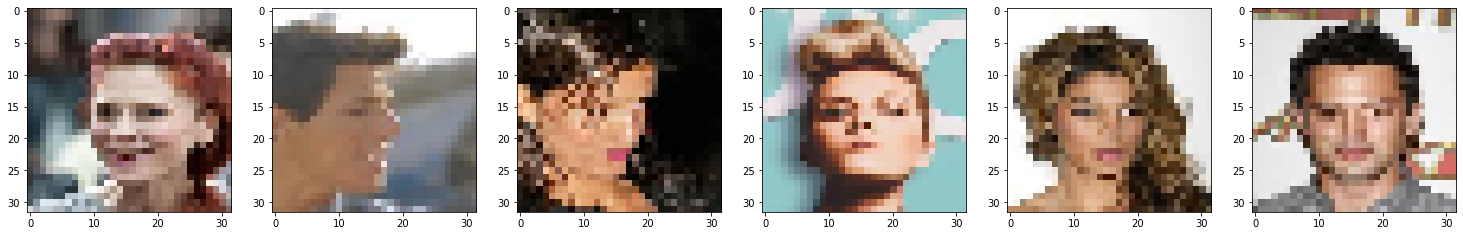

In [21]:
fig = plt.figure(figsize=(30,10))
nplot = 7
for count in range(1,nplot):
    ax = fig.add_subplot(1,nplot,count)
    ax.imshow(X_train[count])
plt.show()

## generator

In [22]:
import numpy as np
from keras import layers, models
from keras.optimizers import Adam

## optimizer
#optimizer = Adam(0.0002, 0.5)
optimizer = Adam(0.00007, 0.5)

def build_generator(img_shape, noise_shape = (100,)):
    '''
    noise_shape : the dimension of the input vector for the generator
    img_shape   : the dimension of the output
    '''
    ## latent variable as input
    input_noise = layers.Input(shape=noise_shape) 
    d = layers.Dense(1024, activation="relu")(input_noise) 
    d = layers.Dense(1024, activation="relu")(input_noise) 
    d = layers.Dense(128*8*8, activation="relu")(d)
    d = layers.Reshape((8,8,128))(d)
    
    d = layers.Conv2DTranspose(128, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
    d = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_4")(d) ## 16,16


    d = layers.Conv2DTranspose(32, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
    d = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_5")(d) ## 32,32
    
    if img_shape[0] == 64:
        d = layers.Conv2DTranspose(32, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
        d = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_6")(d) ## 64,64
    
    img = layers.Conv2D( 3 , ( 1 , 1 ) , activation='sigmoid' , padding='same', name="final_block")(d) ## 32, 32
    model = models.Model(input_noise, img)
    model.summary() 
    return(model)

## Set the dimension of latent variables to be 100
noise_shape = (100,)

generator = build_generator(img_shape, noise_shape = noise_shape)

generator.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dense_2 (Dense)              (None, 8192)              8396800   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       65536     
_________________________________________________________________
block_4 (Conv2D)             (None, 16, 16, 64)        8256      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 32)       

### generated images before training

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


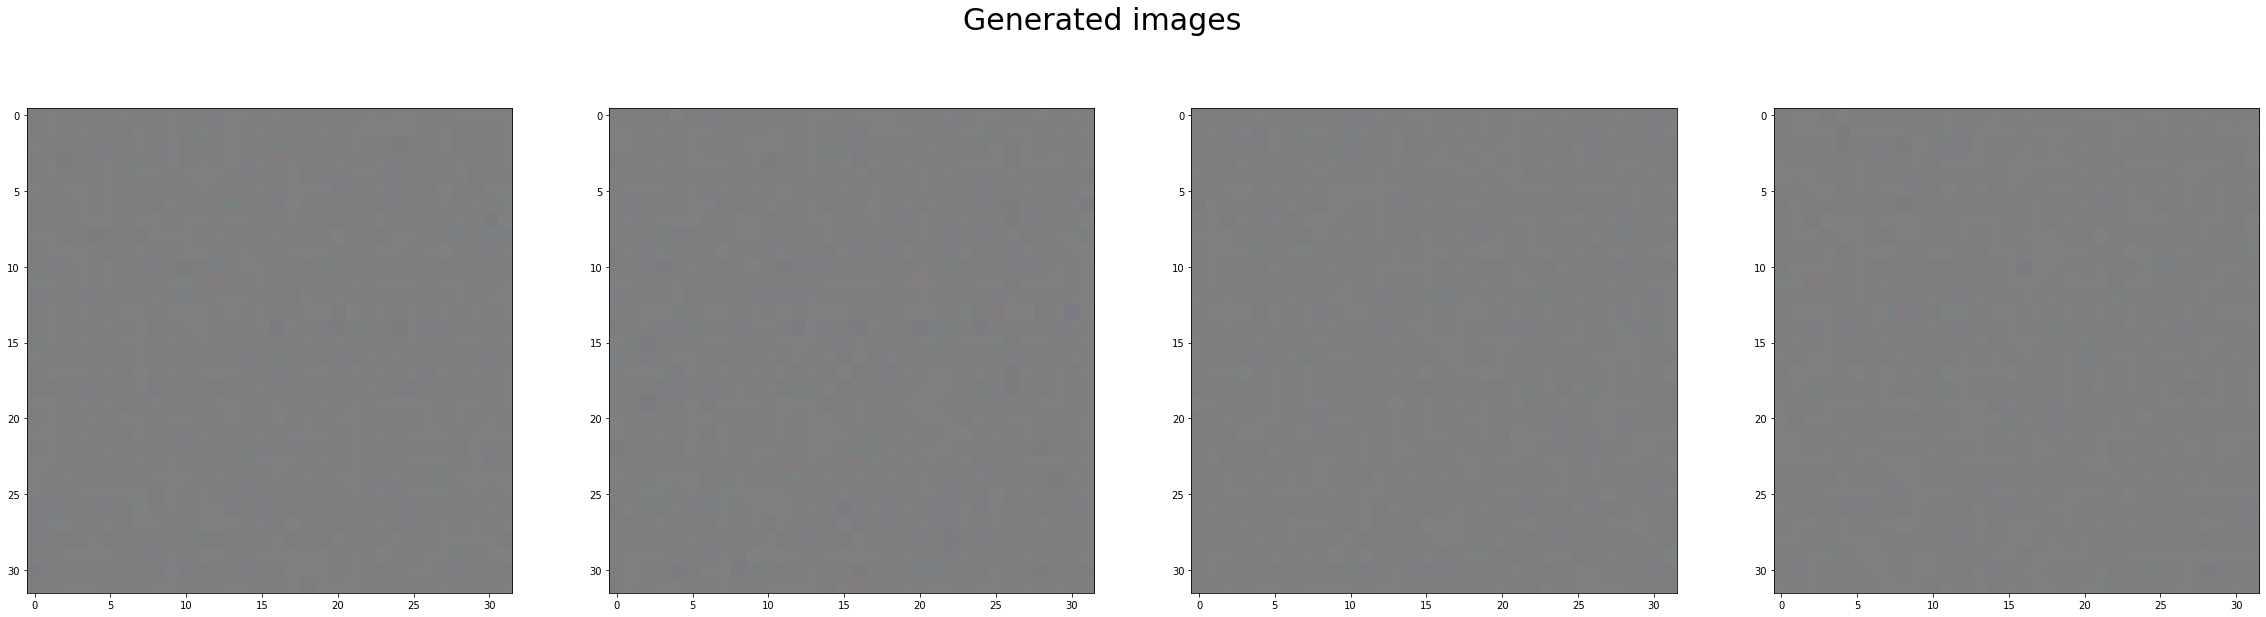

In [23]:
def get_noise(nsample=1, nlatent_dim=100):
    noise = np.random.normal(0, 1, (nsample,nlatent_dim))
    return(noise)

def plot_generated_images(noise,path_save=None,titleadd=""):
    imgs = generator.predict(noise)
    fig = plt.figure(figsize=(40,10))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(1,nsample,i+1)
        ax.imshow(img)
    fig.suptitle("Generated images "+titleadd,fontsize=30)
    
    if path_save is not None:
        plt.savefig(path_save,
                    bbox_inches='tight',
                    pad_inches=0)
        plt.close()
    else:
        plt.show()

nsample = 4
noise = get_noise(nsample=nsample, nlatent_dim=noise_shape[0])
plot_generated_images(noise)

# Define discriminator

In [24]:
def build_discriminator(img_shape,noutput=1):
    input_img = layers.Input(shape=img_shape)
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_img)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(1, 1), name='block4_pool')(x)

    
    x         = layers.Flatten()(x)
    x         = layers.Dense(1024,      activation="relu")(x)
    out       = layers.Dense(noutput,   activation='sigmoid')(x)
    model     = models.Model(input_img, out)
    
    return model

discriminator  = build_discriminator(img_shape)
discriminator.compile(loss      = 'binary_crossentropy', 
                      optimizer = optimizer,
                      metrics   = ['accuracy'])

discriminator.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 32)        896       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 32)        9248      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 64)        18496     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 64)         

In [25]:
z = layers.Input(shape=noise_shape)
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The valid takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = models.Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
combined.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
functional_1 (Functional)    (None, 32, 32, 3)         8584515   
_________________________________________________________________
functional_3 (Functional)    (None, 1)                 6711585   
Total params: 15,296,100
Trainable params: 8,584,515
Non-trainable params: 6,711,585
_________________________________________________________________


# Training

Epoch 00000 [D loss: 0.729, acc.: 050.0%] [G loss: 0.629]


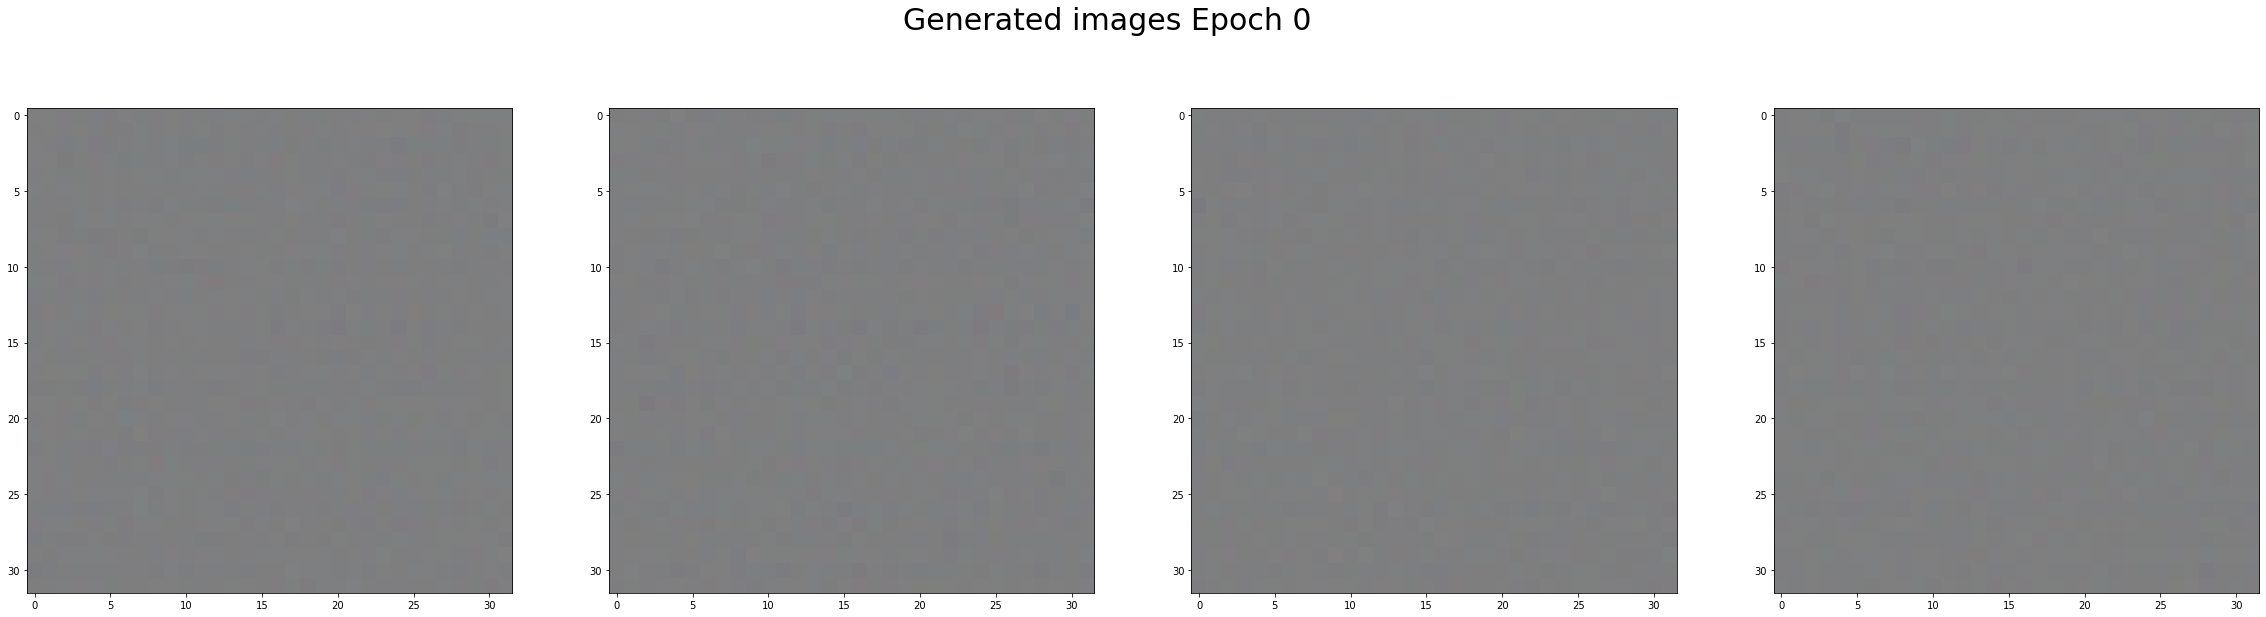

Epoch 00100 [D loss: 0.052, acc.: 099.3%] [G loss: 5.944]
Epoch 00200 [D loss: 0.381, acc.: 093.0%] [G loss: 4.034]
Epoch 00300 [D loss: 0.315, acc.: 087.3%] [G loss: 2.481]
Epoch 00400 [D loss: 0.367, acc.: 085.6%] [G loss: 2.067]
Epoch 00500 [D loss: 0.296, acc.: 089.0%] [G loss: 2.534]
Epoch 00600 [D loss: 0.202, acc.: 093.4%] [G loss: 2.488]
Epoch 00700 [D loss: 0.109, acc.: 097.4%] [G loss: 2.915]
Epoch 00800 [D loss: 0.132, acc.: 096.8%] [G loss: 3.037]
Epoch 00900 [D loss: 0.339, acc.: 089.2%] [G loss: 2.352]
Epoch 01000 [D loss: 0.321, acc.: 086.7%] [G loss: 2.414]


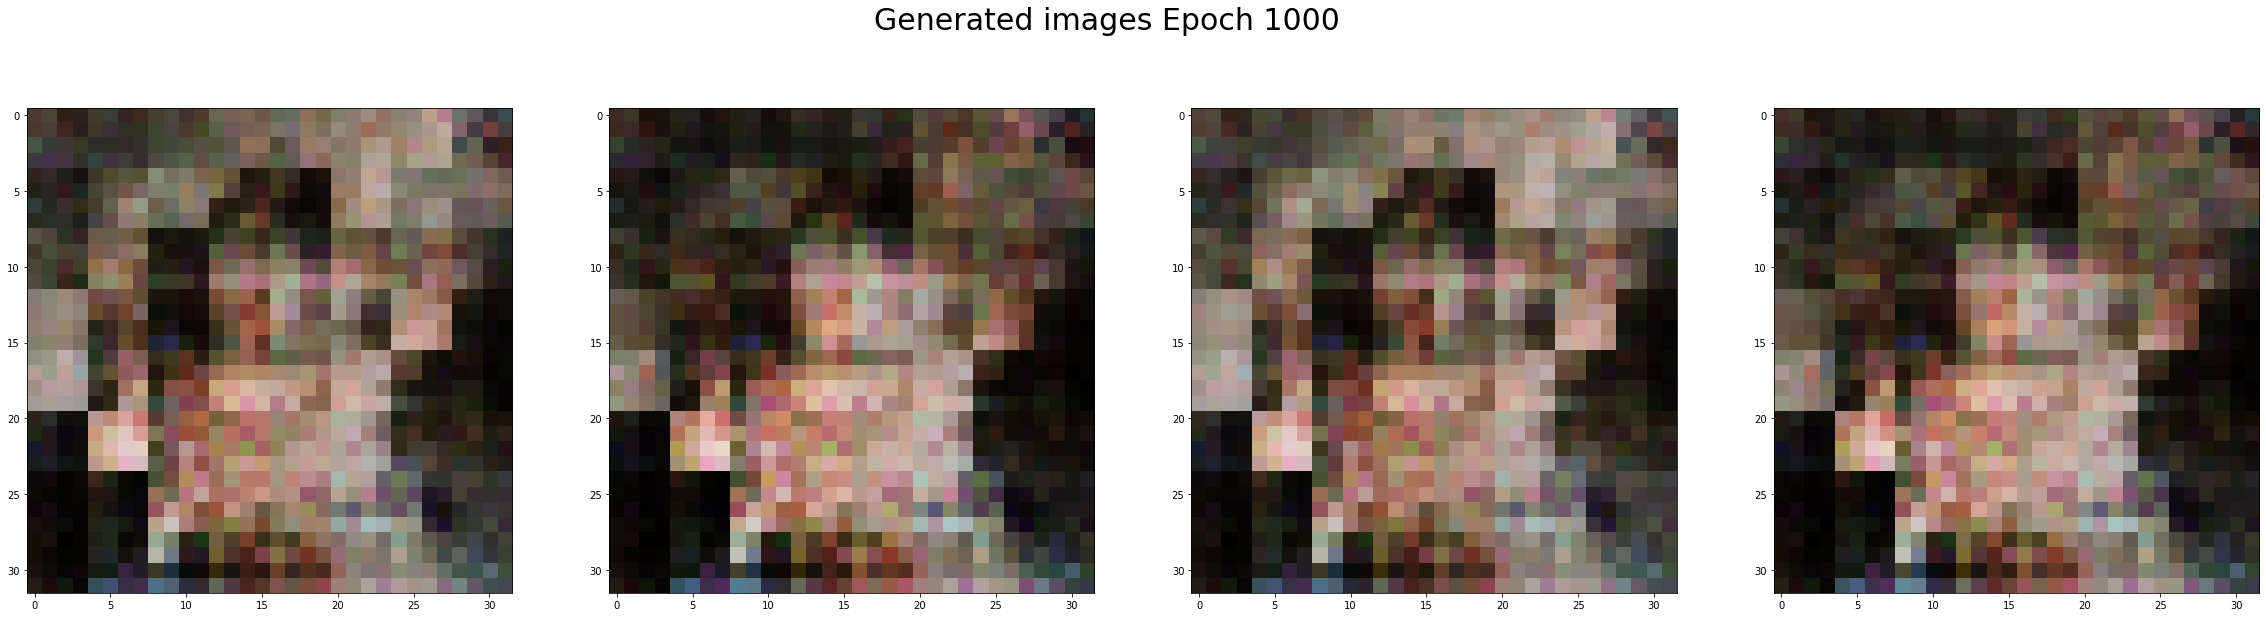

Epoch 01100 [D loss: 0.174, acc.: 094.8%] [G loss: 2.796]
Epoch 01200 [D loss: 0.238, acc.: 090.9%] [G loss: 2.917]
Epoch 01300 [D loss: 0.139, acc.: 095.3%] [G loss: 4.262]
Epoch 01400 [D loss: 0.261, acc.: 089.4%] [G loss: 2.968]
Epoch 01500 [D loss: 0.258, acc.: 090.5%] [G loss: 3.974]
Epoch 01600 [D loss: 0.263, acc.: 089.3%] [G loss: 2.982]
Epoch 01700 [D loss: 0.192, acc.: 093.7%] [G loss: 2.488]
Epoch 01800 [D loss: 0.256, acc.: 092.1%] [G loss: 2.324]
Epoch 01900 [D loss: 0.253, acc.: 092.9%] [G loss: 2.657]
Epoch 02000 [D loss: 0.348, acc.: 085.9%] [G loss: 3.335]


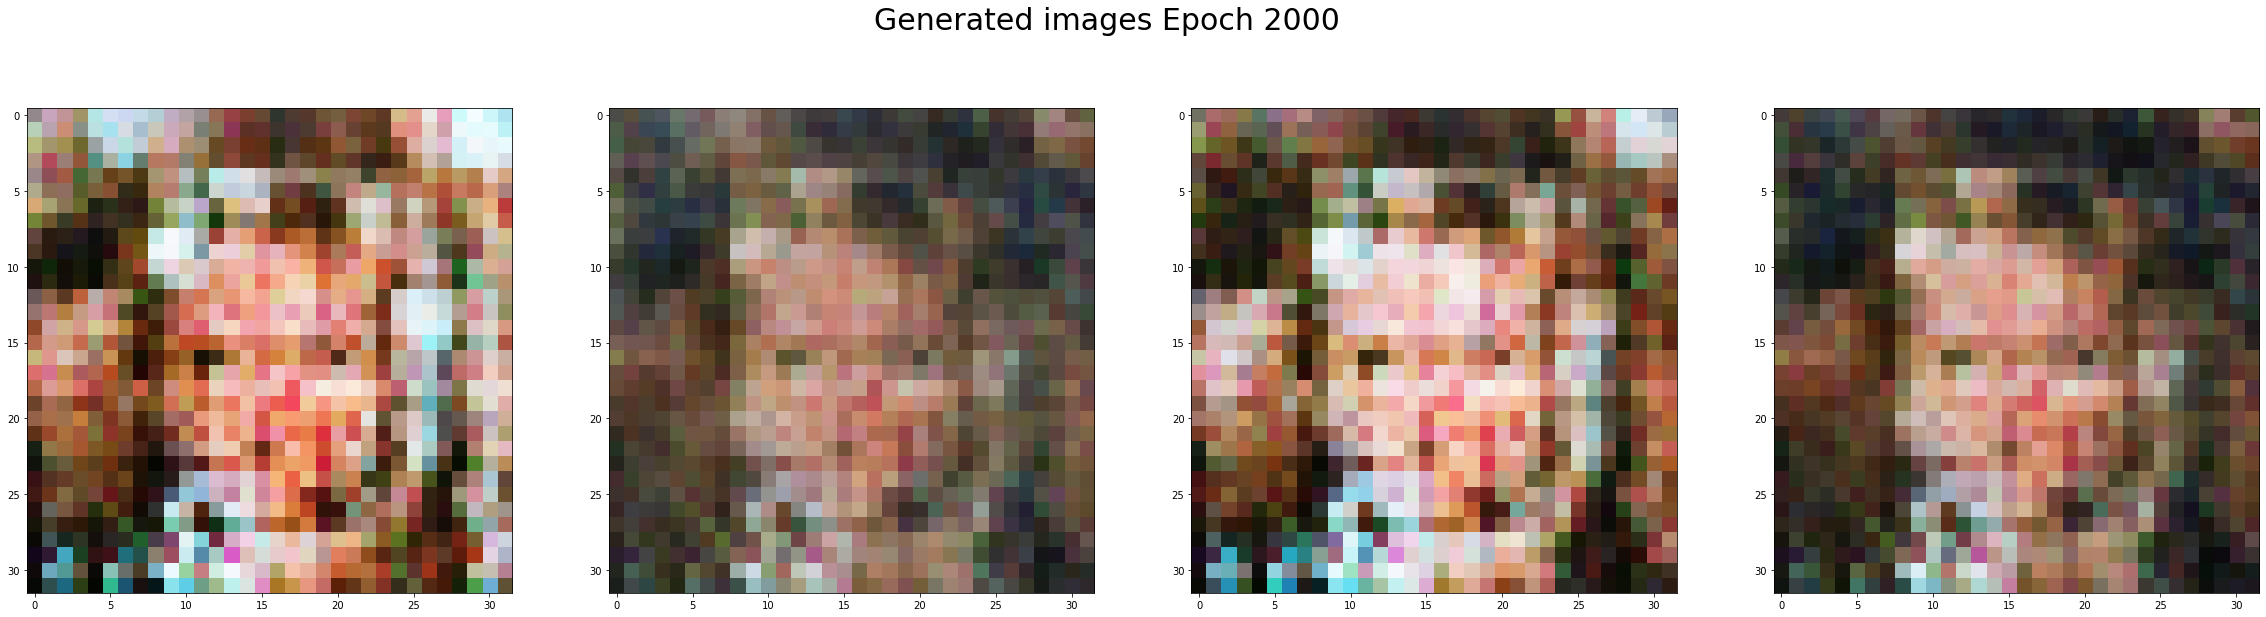

Epoch 02100 [D loss: 0.315, acc.: 086.7%] [G loss: 4.655]
Epoch 02200 [D loss: 0.237, acc.: 091.3%] [G loss: 3.371]
Epoch 02300 [D loss: 0.185, acc.: 093.8%] [G loss: 3.060]
Epoch 02400 [D loss: 0.291, acc.: 088.5%] [G loss: 3.419]
Epoch 02500 [D loss: 0.302, acc.: 089.0%] [G loss: 2.640]
Epoch 02600 [D loss: 0.359, acc.: 086.0%] [G loss: 2.281]
Epoch 02700 [D loss: 0.340, acc.: 086.2%] [G loss: 2.419]
Epoch 02800 [D loss: 0.402, acc.: 083.2%] [G loss: 2.436]
Epoch 02900 [D loss: 0.429, acc.: 081.5%] [G loss: 1.937]
Epoch 03000 [D loss: 0.404, acc.: 083.8%] [G loss: 1.941]


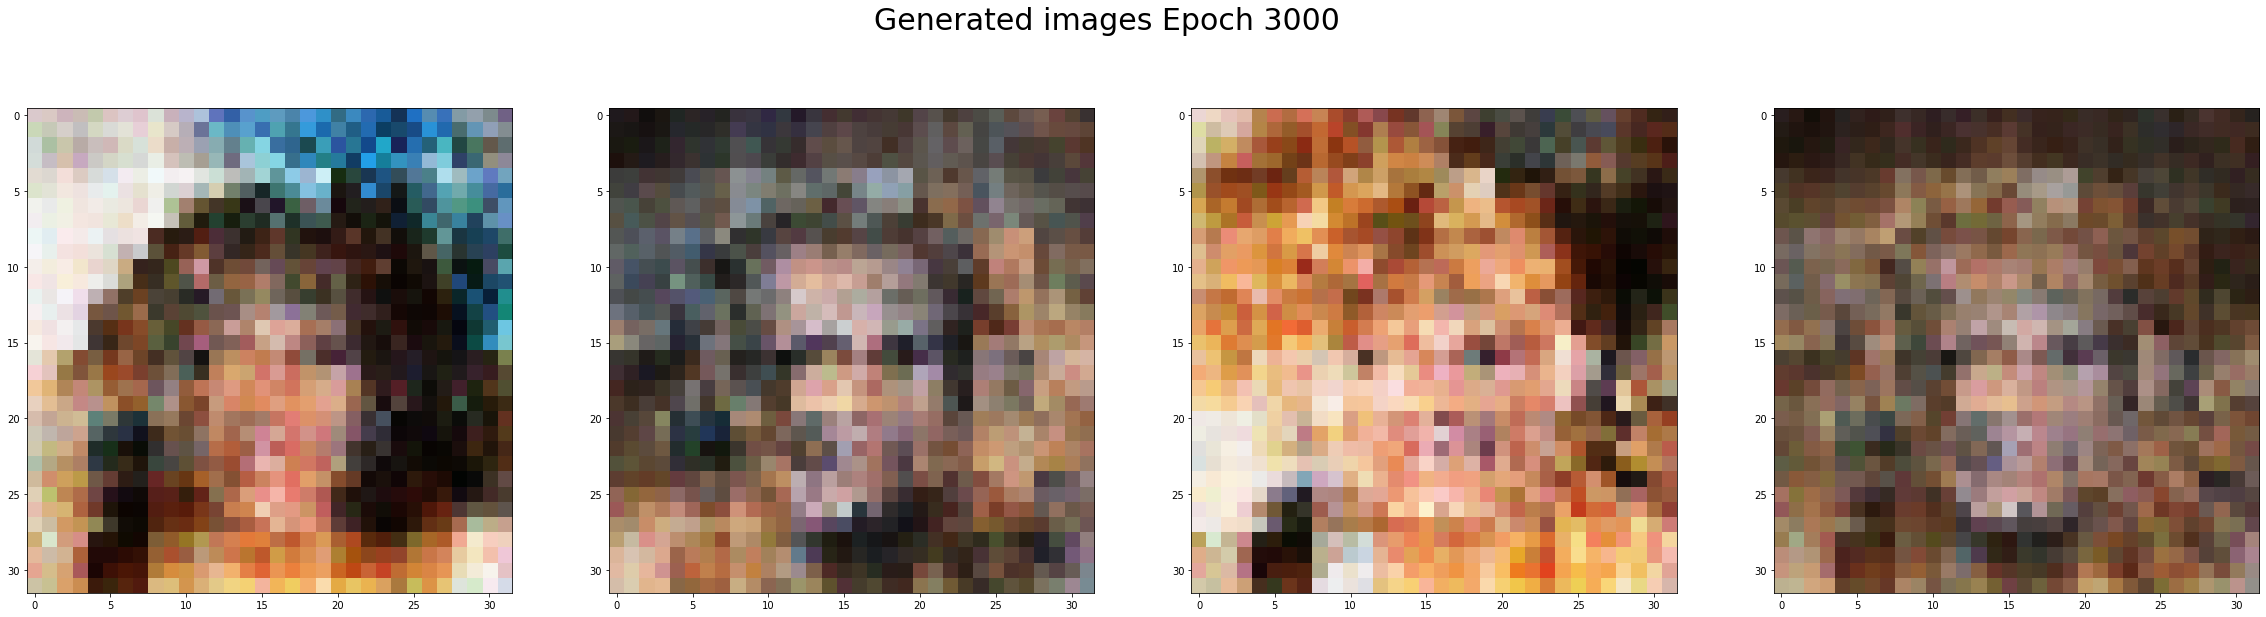

Epoch 03100 [D loss: 0.509, acc.: 077.3%] [G loss: 2.036]
Epoch 03200 [D loss: 0.414, acc.: 083.0%] [G loss: 2.006]
Epoch 03300 [D loss: 0.446, acc.: 080.9%] [G loss: 1.863]
Epoch 03400 [D loss: 0.413, acc.: 082.8%] [G loss: 1.866]
Epoch 03500 [D loss: 0.407, acc.: 084.3%] [G loss: 1.970]
Epoch 03600 [D loss: 0.394, acc.: 082.9%] [G loss: 1.899]
Epoch 03700 [D loss: 0.359, acc.: 085.9%] [G loss: 1.988]
Epoch 03800 [D loss: 0.421, acc.: 082.3%] [G loss: 1.898]
Epoch 03900 [D loss: 0.442, acc.: 079.7%] [G loss: 1.872]
Epoch 04000 [D loss: 0.475, acc.: 079.9%] [G loss: 1.797]


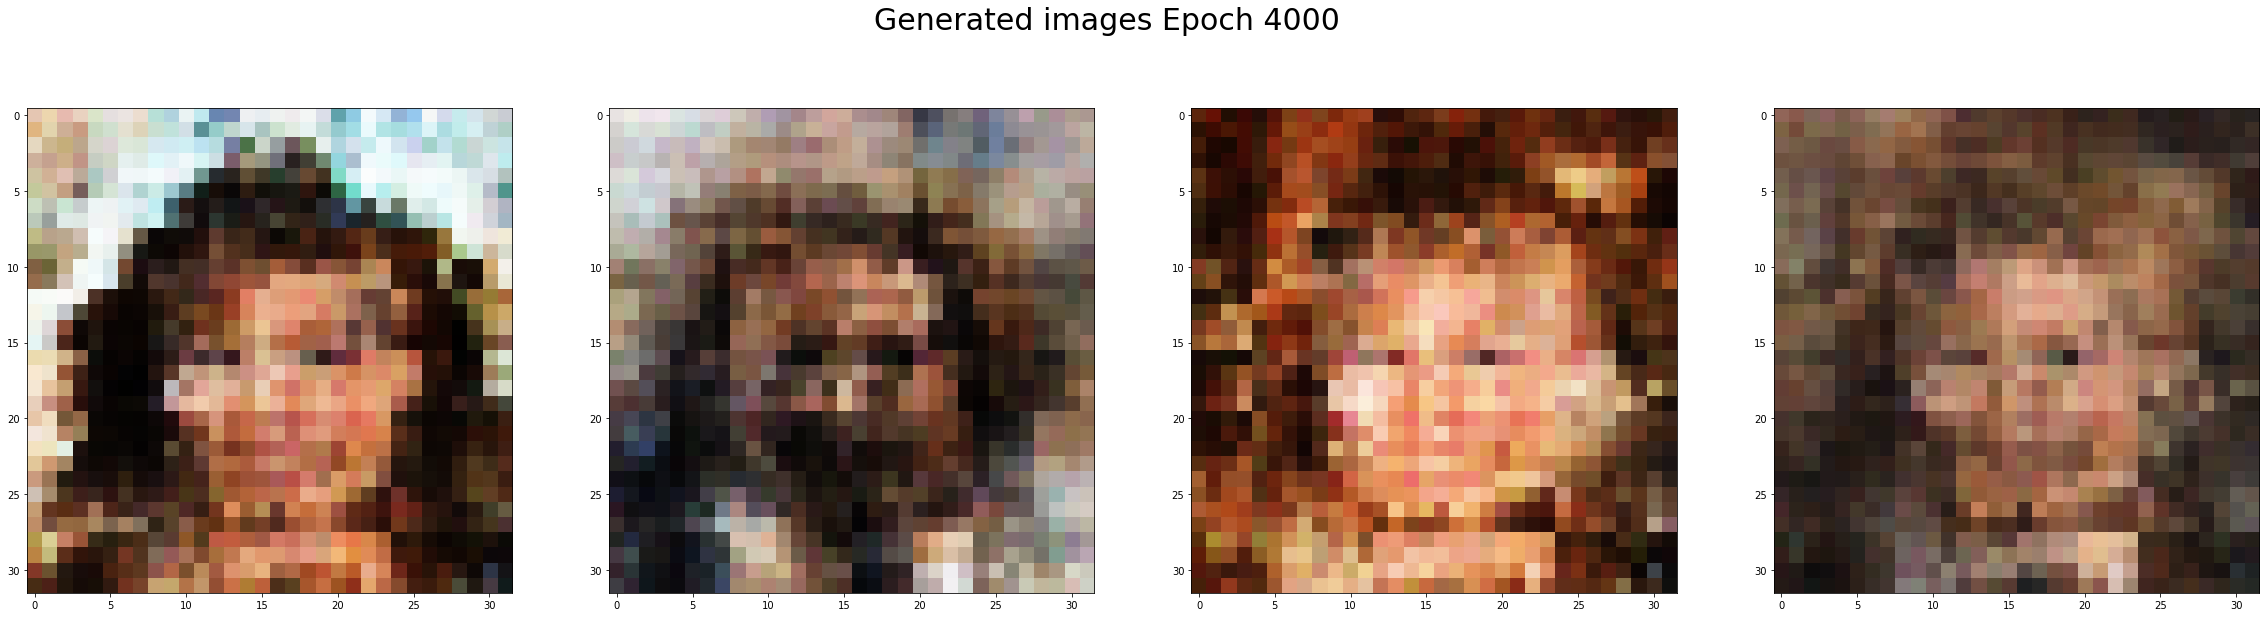

Epoch 04100 [D loss: 0.529, acc.: 076.4%] [G loss: 1.828]
Epoch 04200 [D loss: 0.527, acc.: 073.0%] [G loss: 1.681]
Epoch 04300 [D loss: 0.460, acc.: 077.2%] [G loss: 1.569]
Epoch 04400 [D loss: 0.420, acc.: 082.4%] [G loss: 1.776]
Epoch 04500 [D loss: 0.452, acc.: 080.3%] [G loss: 1.662]
Epoch 04600 [D loss: 0.513, acc.: 073.8%] [G loss: 1.476]
Epoch 04700 [D loss: 0.490, acc.: 076.8%] [G loss: 1.587]
Epoch 04800 [D loss: 0.479, acc.: 077.6%] [G loss: 1.615]
Epoch 04900 [D loss: 0.487, acc.: 076.6%] [G loss: 1.528]
Epoch 05000 [D loss: 0.506, acc.: 076.8%] [G loss: 1.426]


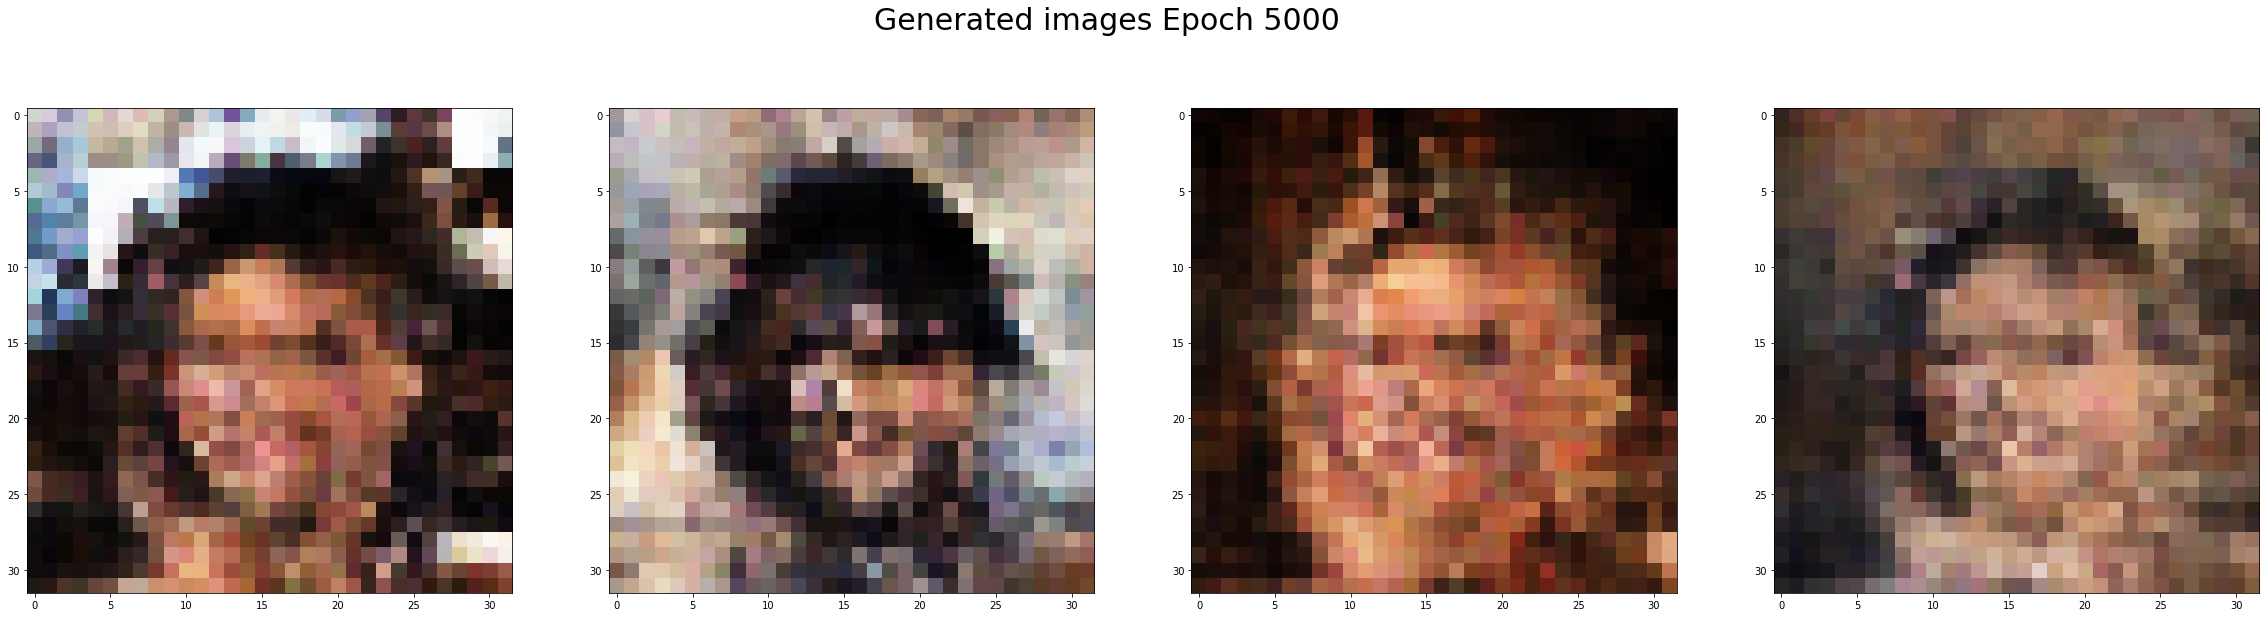

Epoch 05100 [D loss: 0.490, acc.: 076.4%] [G loss: 1.595]
Epoch 05200 [D loss: 0.475, acc.: 077.3%] [G loss: 1.452]
Epoch 05300 [D loss: 0.524, acc.: 074.1%] [G loss: 1.620]
Epoch 05400 [D loss: 0.440, acc.: 080.2%] [G loss: 1.462]
Epoch 05500 [D loss: 0.490, acc.: 076.5%] [G loss: 1.509]
Epoch 05600 [D loss: 0.500, acc.: 075.5%] [G loss: 1.383]
Epoch 05700 [D loss: 0.535, acc.: 071.9%] [G loss: 1.368]
Epoch 05800 [D loss: 0.514, acc.: 073.4%] [G loss: 1.425]
Epoch 05900 [D loss: 0.487, acc.: 077.0%] [G loss: 1.398]
Epoch 06000 [D loss: 0.493, acc.: 075.9%] [G loss: 1.410]


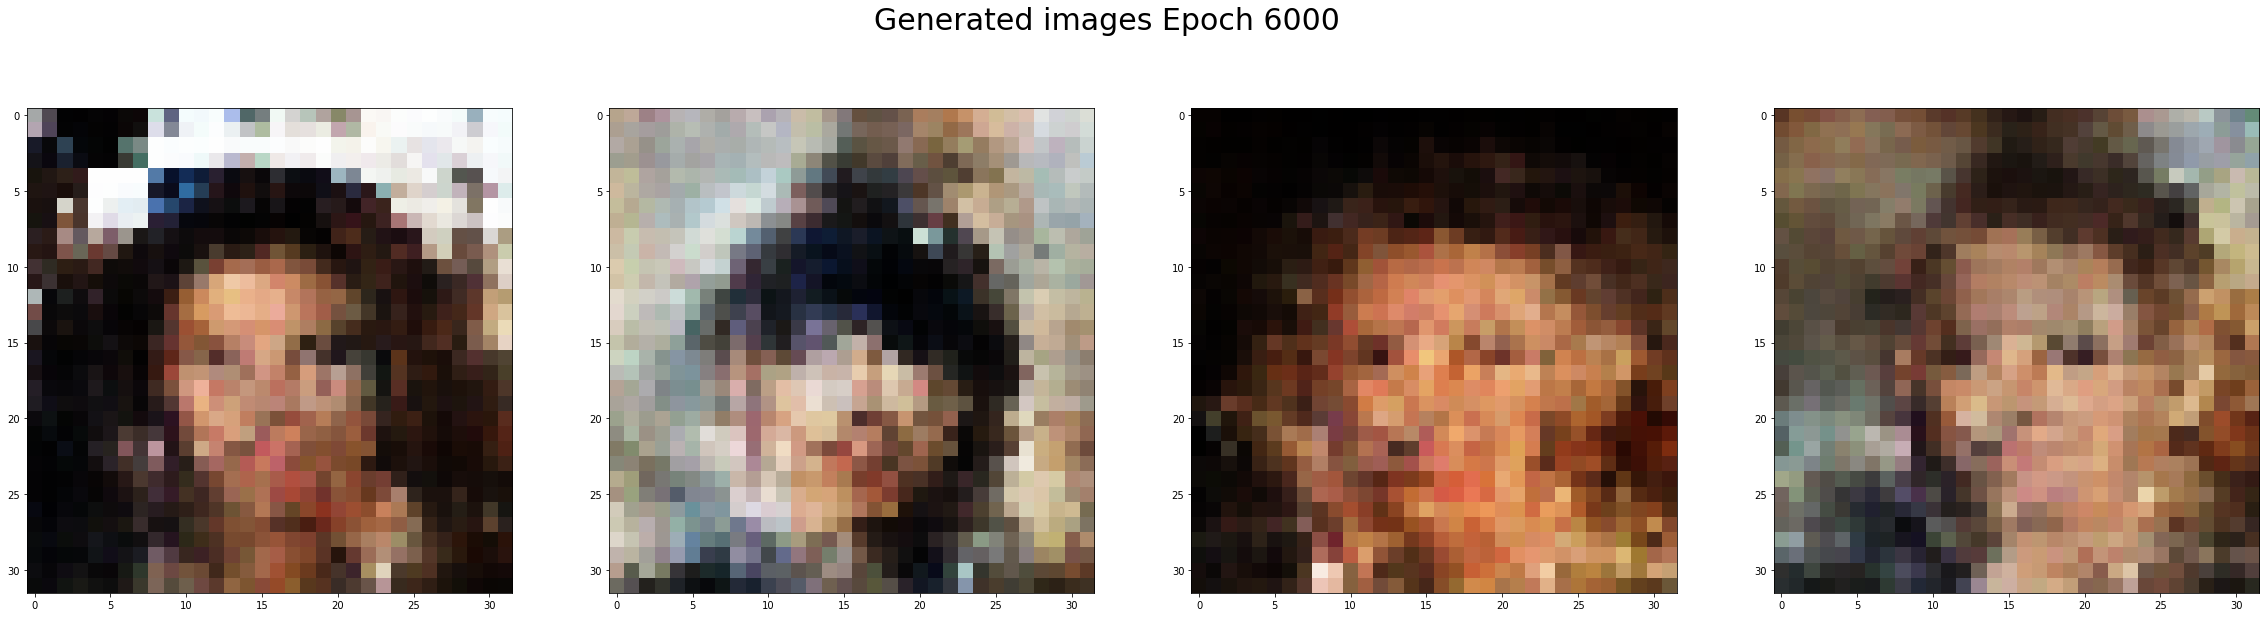

Epoch 06100 [D loss: 0.487, acc.: 076.0%] [G loss: 1.506]
Epoch 06200 [D loss: 0.456, acc.: 078.9%] [G loss: 1.581]
Epoch 06300 [D loss: 0.471, acc.: 077.5%] [G loss: 1.459]
Epoch 06400 [D loss: 0.479, acc.: 076.5%] [G loss: 1.474]
Epoch 06500 [D loss: 0.489, acc.: 076.7%] [G loss: 1.484]
Epoch 06600 [D loss: 0.446, acc.: 078.3%] [G loss: 1.453]
Epoch 06700 [D loss: 0.447, acc.: 079.4%] [G loss: 1.471]
Epoch 06800 [D loss: 0.469, acc.: 078.9%] [G loss: 1.413]
Epoch 06900 [D loss: 0.510, acc.: 075.9%] [G loss: 1.456]
Epoch 07000 [D loss: 0.491, acc.: 075.9%] [G loss: 1.485]


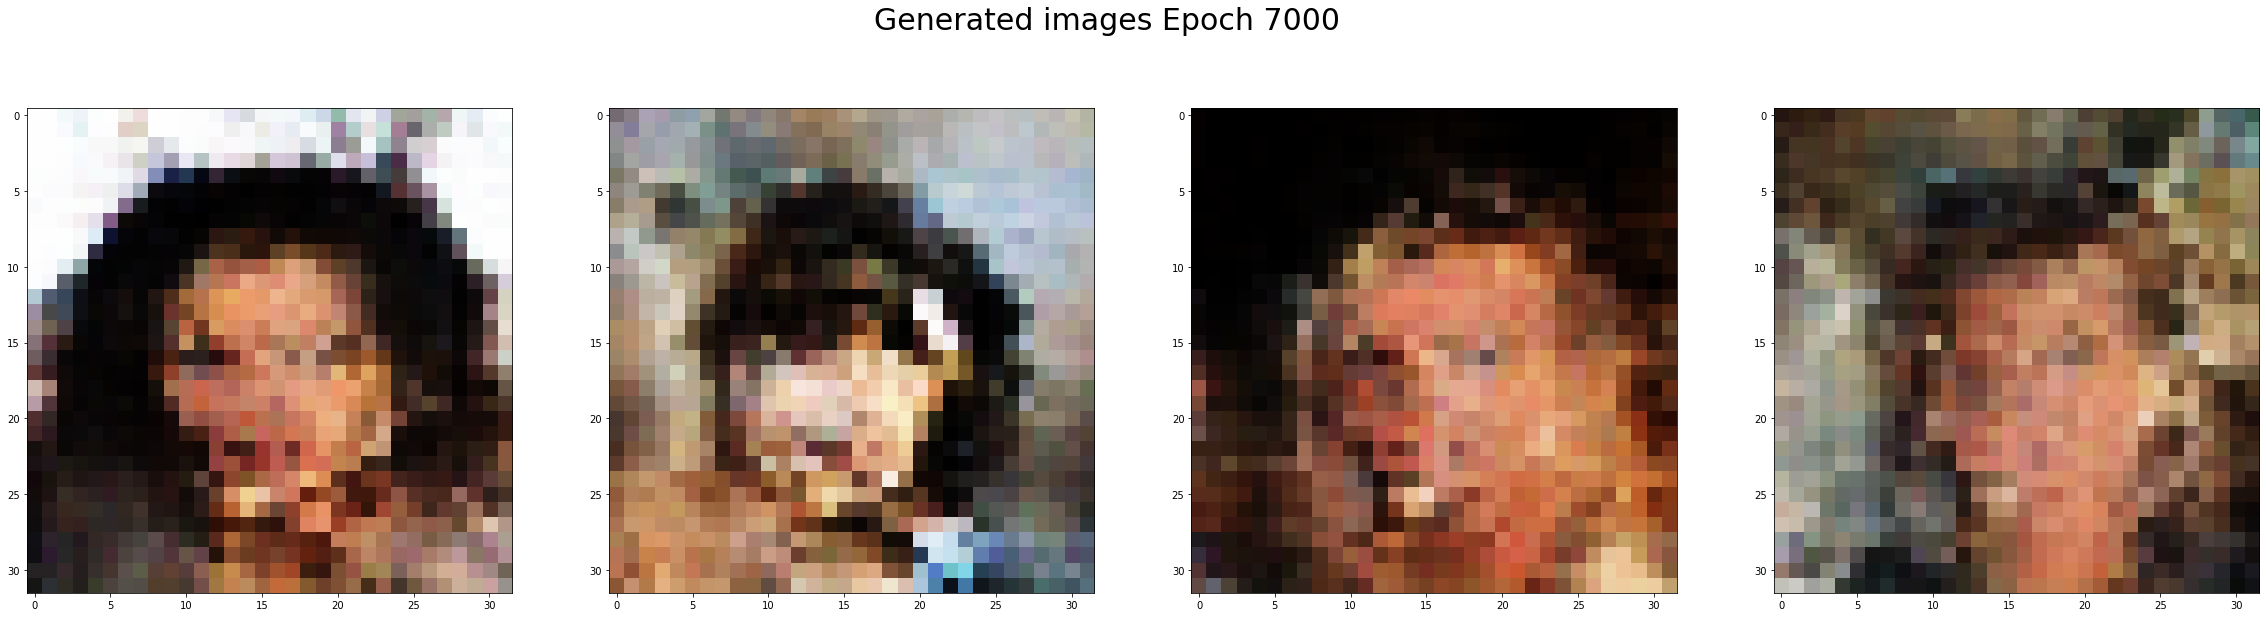

Epoch 07100 [D loss: 0.477, acc.: 078.4%] [G loss: 1.394]
Epoch 07200 [D loss: 0.455, acc.: 078.1%] [G loss: 1.456]
Epoch 07300 [D loss: 0.468, acc.: 077.3%] [G loss: 1.516]
Epoch 07400 [D loss: 0.465, acc.: 077.6%] [G loss: 1.421]
Epoch 07500 [D loss: 0.500, acc.: 076.6%] [G loss: 1.415]
Epoch 07600 [D loss: 0.501, acc.: 075.4%] [G loss: 1.421]
Epoch 07700 [D loss: 0.466, acc.: 078.0%] [G loss: 1.397]
Epoch 07800 [D loss: 0.451, acc.: 080.4%] [G loss: 1.426]
Epoch 07900 [D loss: 0.409, acc.: 081.8%] [G loss: 1.534]
Epoch 08000 [D loss: 0.456, acc.: 078.5%] [G loss: 1.442]


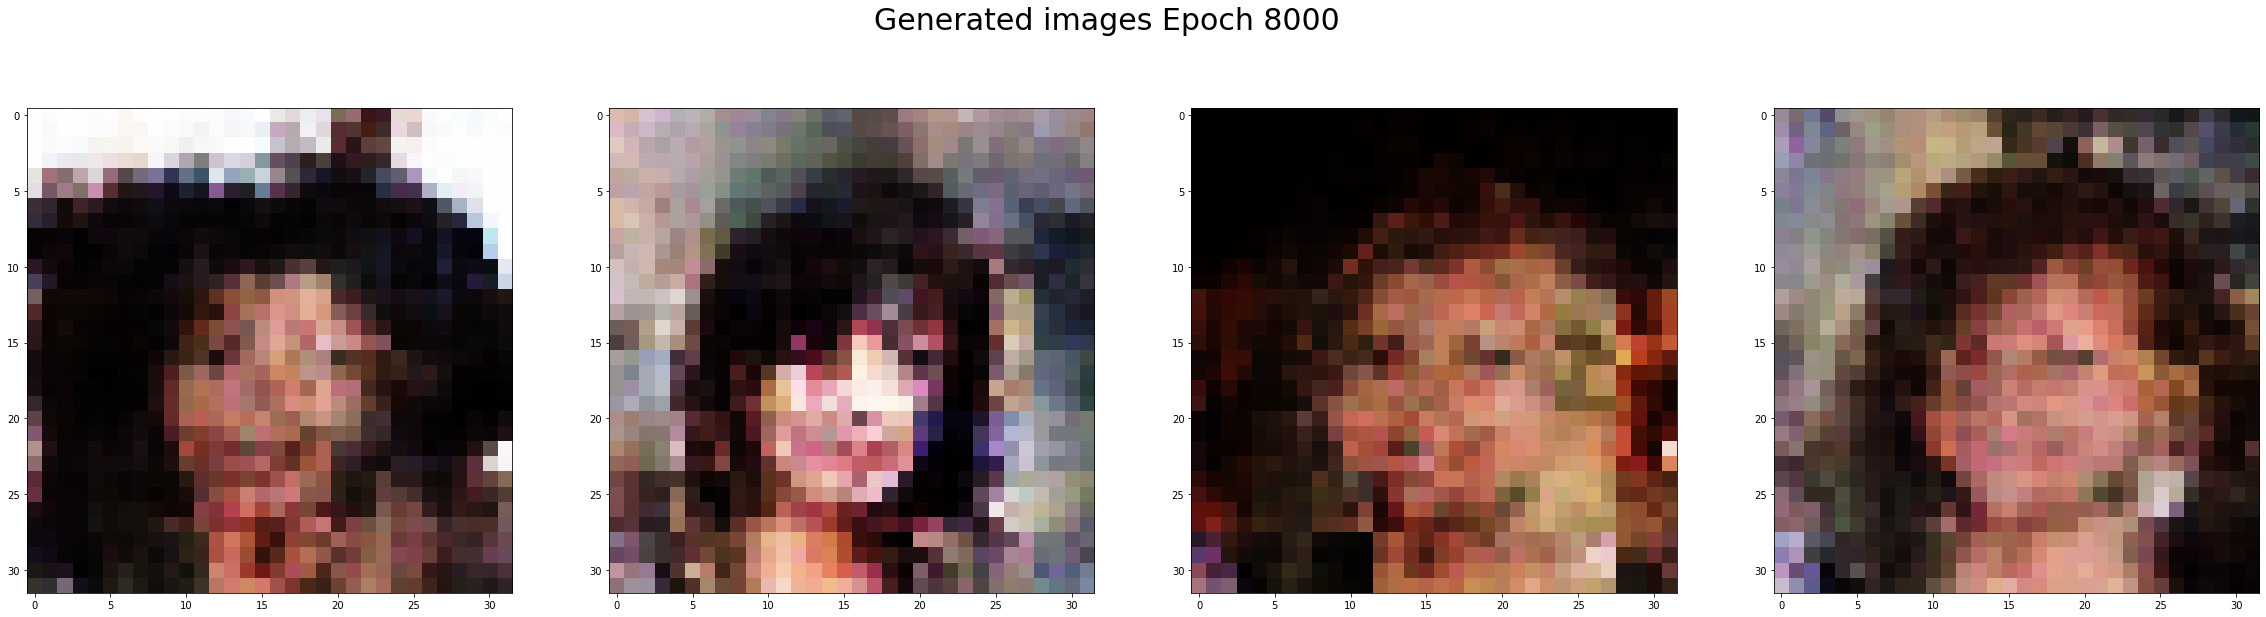

Epoch 08100 [D loss: 0.487, acc.: 076.0%] [G loss: 1.469]
Epoch 08200 [D loss: 0.485, acc.: 074.9%] [G loss: 1.339]
Epoch 08300 [D loss: 0.475, acc.: 077.7%] [G loss: 1.510]
Epoch 08400 [D loss: 0.457, acc.: 079.3%] [G loss: 1.584]
Epoch 08500 [D loss: 0.485, acc.: 076.7%] [G loss: 1.448]
Epoch 08600 [D loss: 0.493, acc.: 075.6%] [G loss: 1.401]
Epoch 08700 [D loss: 0.467, acc.: 077.4%] [G loss: 1.342]
Epoch 08800 [D loss: 0.454, acc.: 079.0%] [G loss: 1.393]
Epoch 08900 [D loss: 0.473, acc.: 078.1%] [G loss: 1.395]
Epoch 09000 [D loss: 0.492, acc.: 075.9%] [G loss: 1.387]


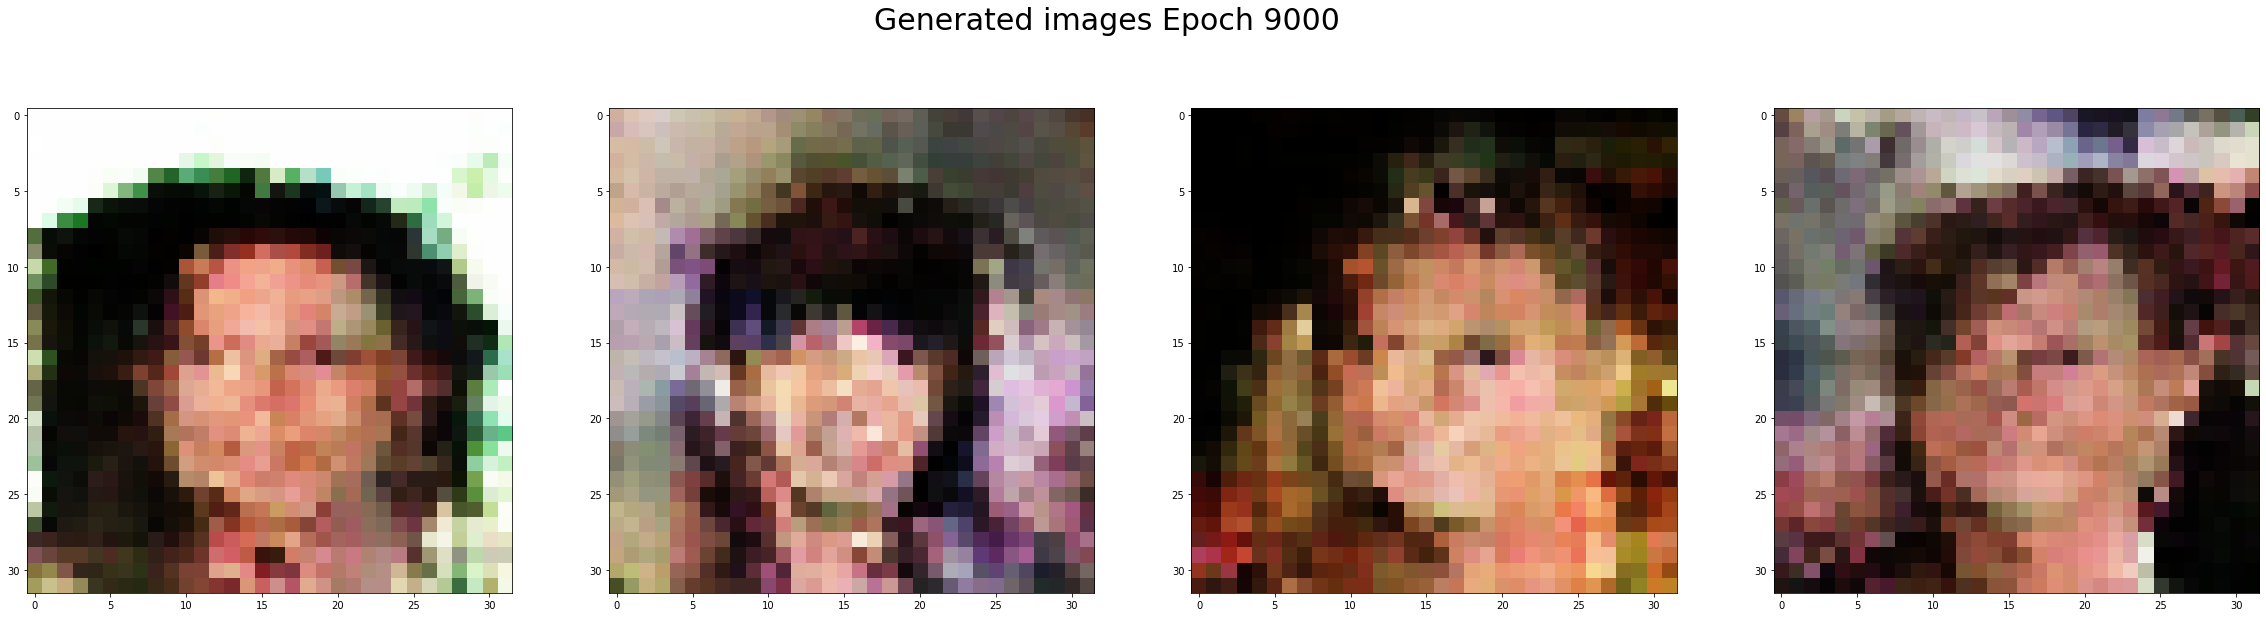

Epoch 09100 [D loss: 0.454, acc.: 077.0%] [G loss: 1.365]
Epoch 09200 [D loss: 0.482, acc.: 076.3%] [G loss: 1.296]
Epoch 09300 [D loss: 0.472, acc.: 077.4%] [G loss: 1.332]
Epoch 09400 [D loss: 0.507, acc.: 074.1%] [G loss: 1.407]
Epoch 09500 [D loss: 0.492, acc.: 076.4%] [G loss: 1.280]
Epoch 09600 [D loss: 0.489, acc.: 076.4%] [G loss: 1.297]
Epoch 09700 [D loss: 0.506, acc.: 074.0%] [G loss: 1.313]
Epoch 09800 [D loss: 0.506, acc.: 075.0%] [G loss: 1.274]
Epoch 09900 [D loss: 0.523, acc.: 075.1%] [G loss: 1.284]
Epoch 10000 [D loss: 0.511, acc.: 073.7%] [G loss: 1.247]


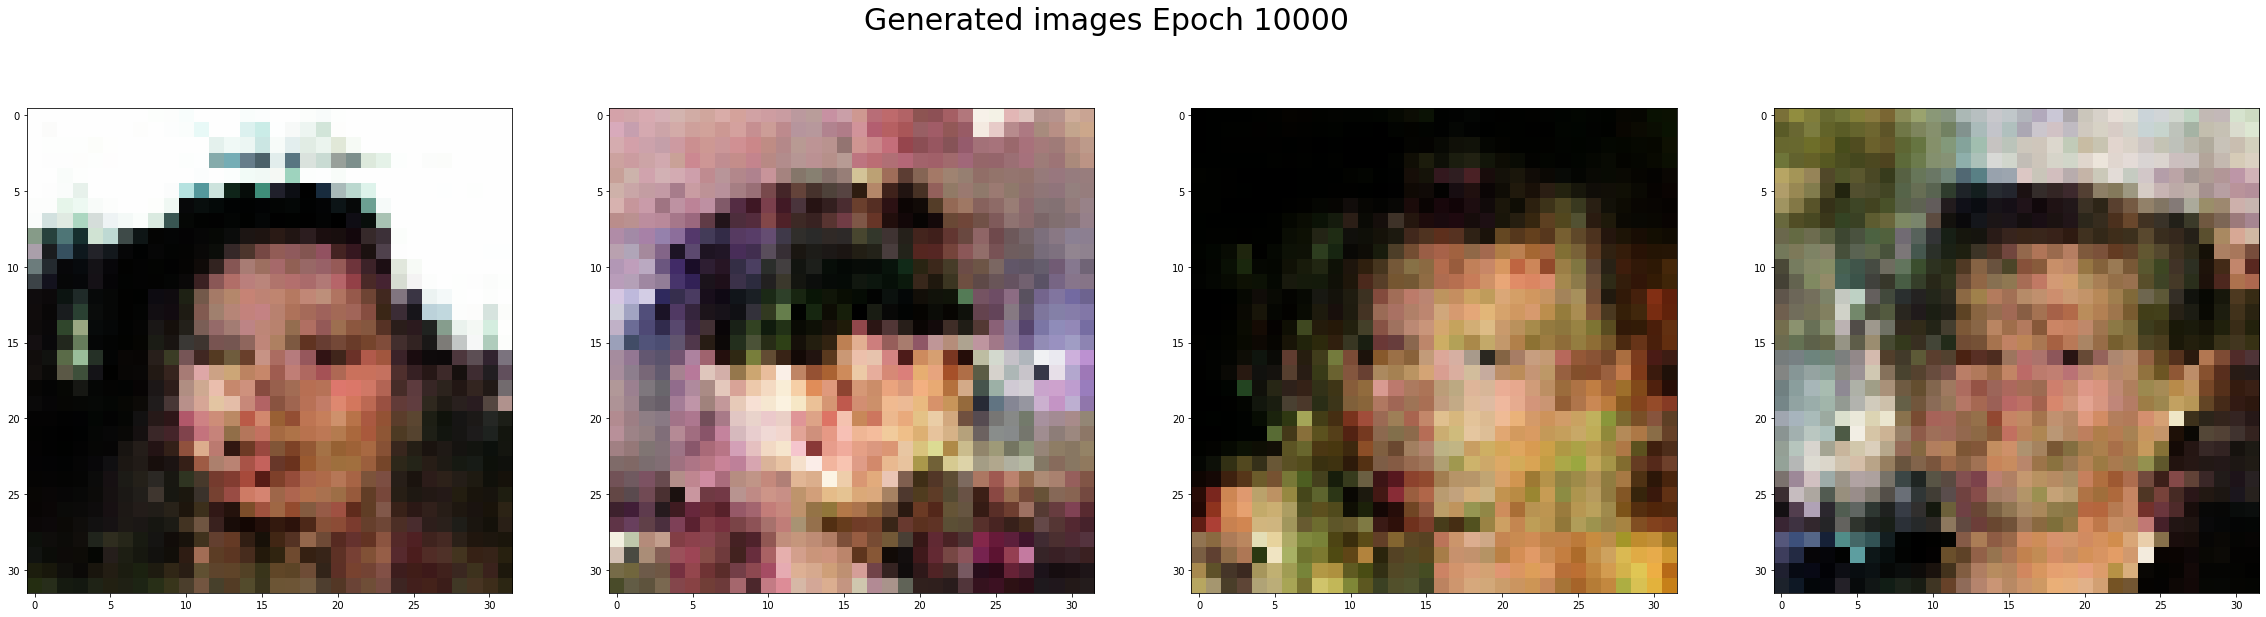

Epoch 10100 [D loss: 0.499, acc.: 075.4%] [G loss: 1.277]
Epoch 10200 [D loss: 0.485, acc.: 076.5%] [G loss: 1.335]
Epoch 10300 [D loss: 0.543, acc.: 071.8%] [G loss: 1.286]
Epoch 10400 [D loss: 0.513, acc.: 072.7%] [G loss: 1.326]
Epoch 10500 [D loss: 0.470, acc.: 076.8%] [G loss: 1.316]
Epoch 10600 [D loss: 0.501, acc.: 073.6%] [G loss: 1.333]
Epoch 10700 [D loss: 0.520, acc.: 073.5%] [G loss: 1.285]
Epoch 10800 [D loss: 0.543, acc.: 071.7%] [G loss: 1.293]
Epoch 10900 [D loss: 0.521, acc.: 074.9%] [G loss: 1.238]
Epoch 11000 [D loss: 0.500, acc.: 075.5%] [G loss: 1.199]


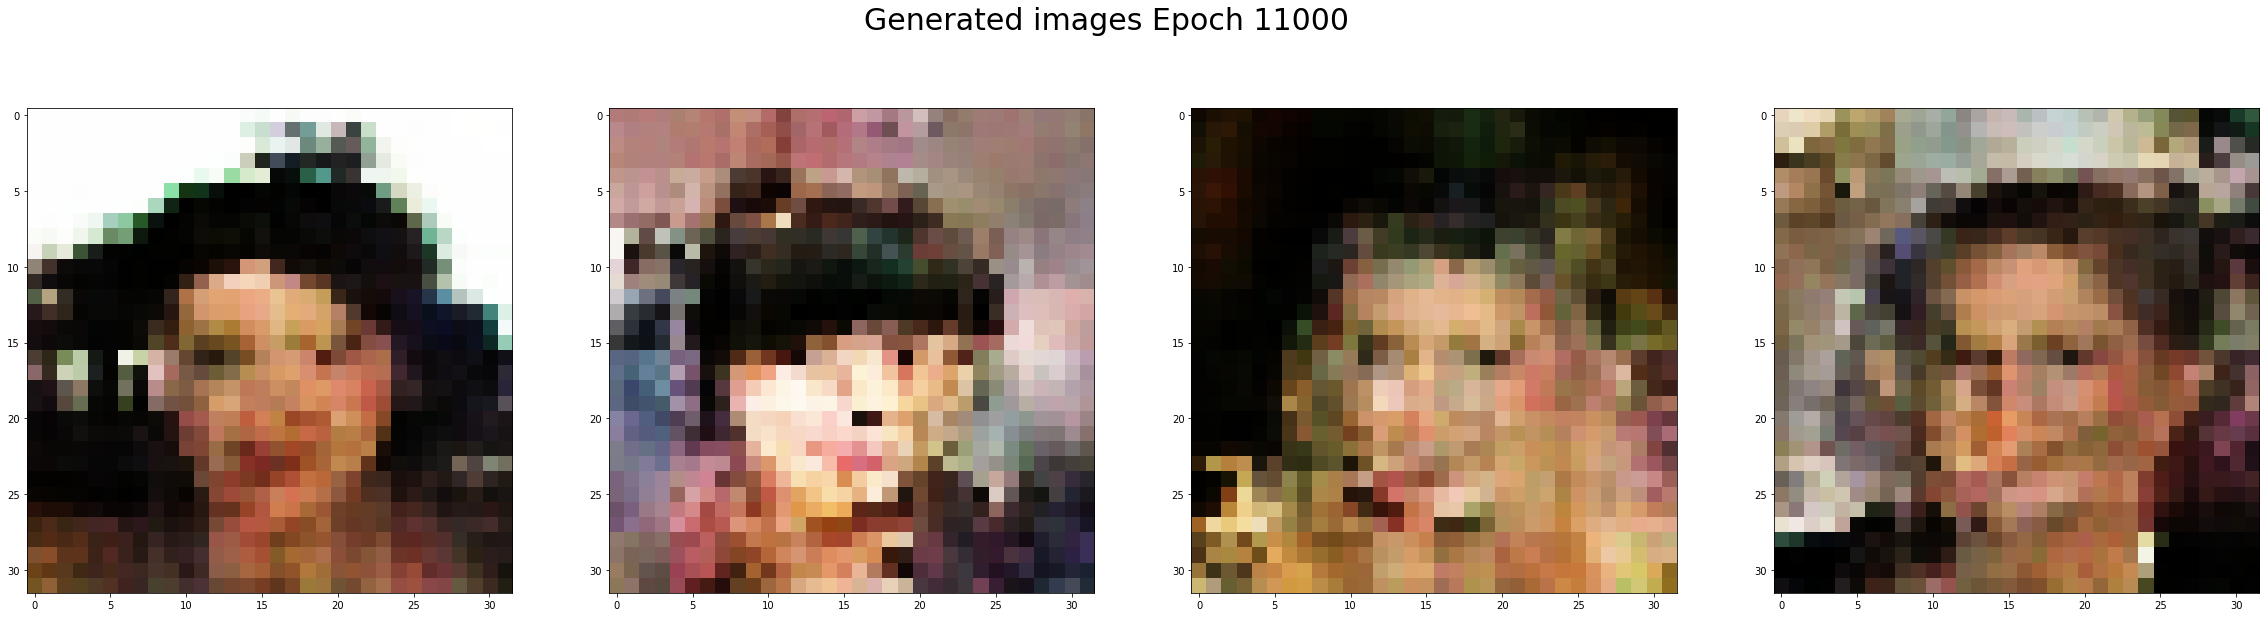

Epoch 11100 [D loss: 0.531, acc.: 073.5%] [G loss: 1.206]
Epoch 11200 [D loss: 0.507, acc.: 075.1%] [G loss: 1.228]
Epoch 11300 [D loss: 0.522, acc.: 073.6%] [G loss: 1.276]
Epoch 11400 [D loss: 0.504, acc.: 074.7%] [G loss: 1.251]
Epoch 11500 [D loss: 0.549, acc.: 071.4%] [G loss: 1.252]
Epoch 11600 [D loss: 0.548, acc.: 070.4%] [G loss: 1.226]
Epoch 11700 [D loss: 0.501, acc.: 073.8%] [G loss: 1.284]
Epoch 11800 [D loss: 0.522, acc.: 072.8%] [G loss: 1.264]
Epoch 11900 [D loss: 0.498, acc.: 075.3%] [G loss: 1.257]
Epoch 12000 [D loss: 0.537, acc.: 071.8%] [G loss: 1.261]


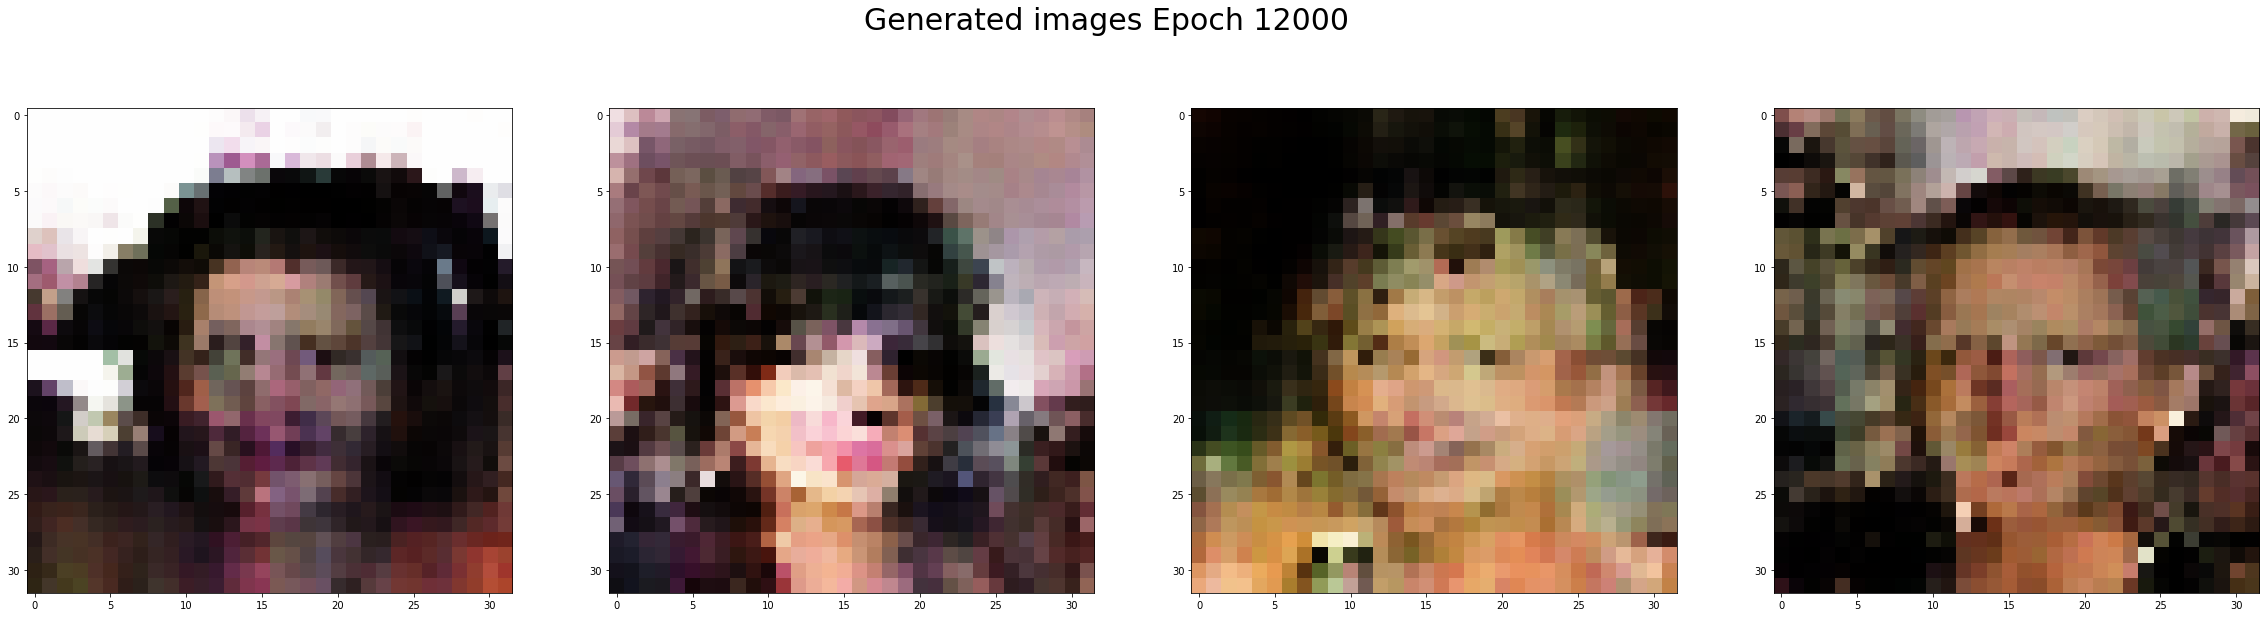

Epoch 12100 [D loss: 0.516, acc.: 074.5%] [G loss: 1.190]
Epoch 12200 [D loss: 0.511, acc.: 074.6%] [G loss: 1.225]
Epoch 12300 [D loss: 0.523, acc.: 071.9%] [G loss: 1.199]
Epoch 12400 [D loss: 0.534, acc.: 072.2%] [G loss: 1.188]
Epoch 12500 [D loss: 0.528, acc.: 072.9%] [G loss: 1.229]
Epoch 12600 [D loss: 0.540, acc.: 071.3%] [G loss: 1.238]
Epoch 12700 [D loss: 0.502, acc.: 074.9%] [G loss: 1.251]
Epoch 12800 [D loss: 0.518, acc.: 073.2%] [G loss: 1.217]
Epoch 12900 [D loss: 0.507, acc.: 074.4%] [G loss: 1.235]
Epoch 13000 [D loss: 0.511, acc.: 074.3%] [G loss: 1.191]


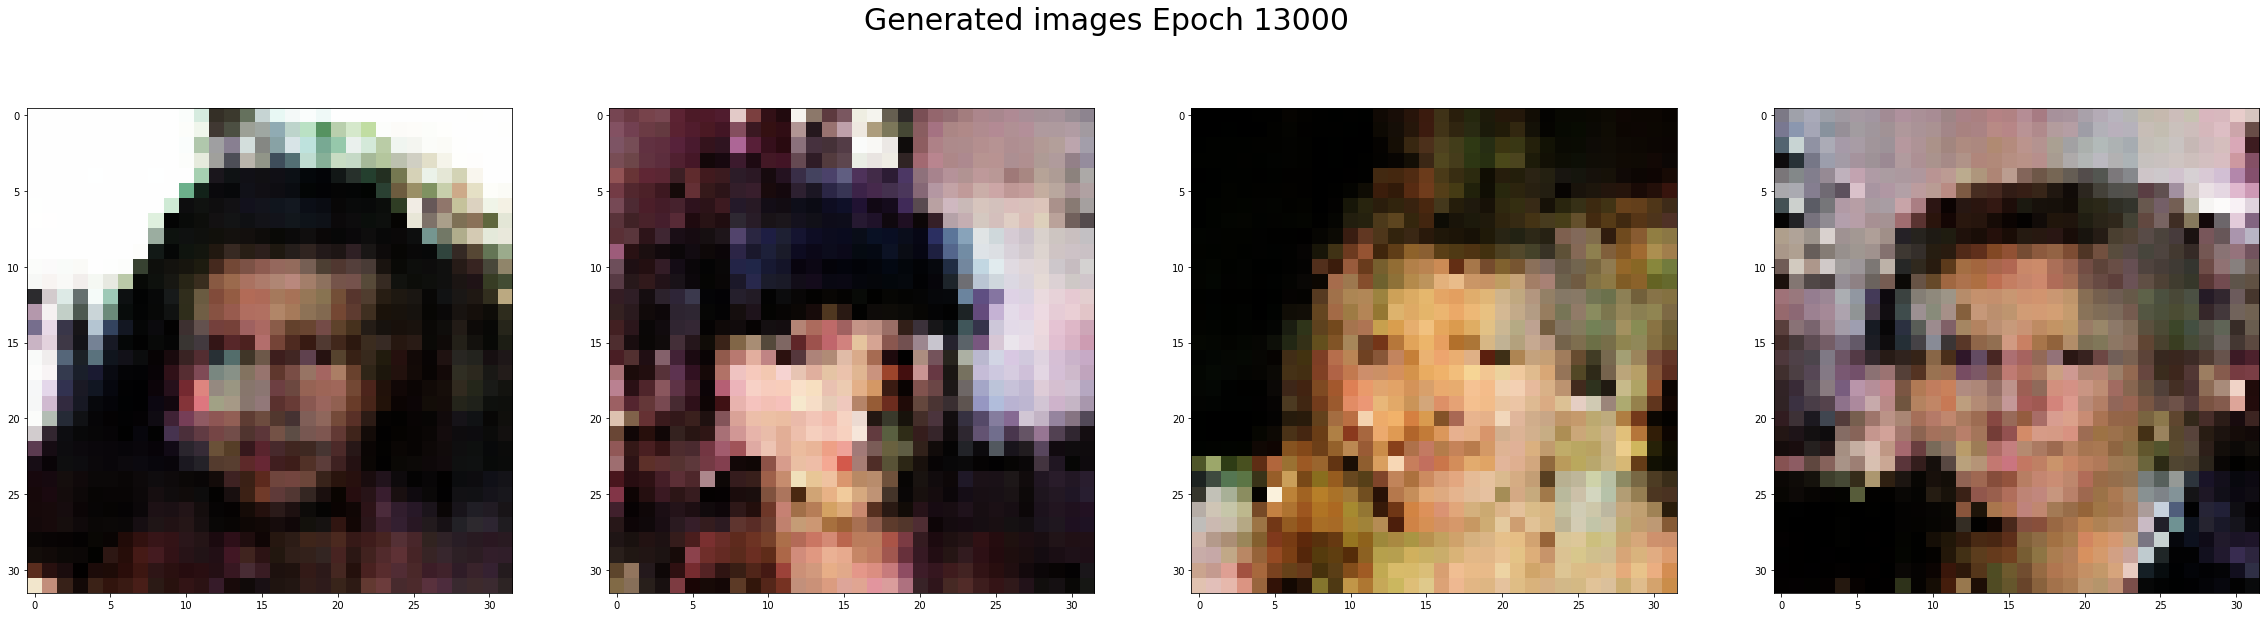

Epoch 13100 [D loss: 0.535, acc.: 071.6%] [G loss: 1.198]
Epoch 13200 [D loss: 0.548, acc.: 072.6%] [G loss: 1.170]
Epoch 13300 [D loss: 0.545, acc.: 072.4%] [G loss: 1.177]
Epoch 13400 [D loss: 0.544, acc.: 072.2%] [G loss: 1.221]
Epoch 13500 [D loss: 0.525, acc.: 073.4%] [G loss: 1.230]
Epoch 13600 [D loss: 0.508, acc.: 076.5%] [G loss: 1.177]
Epoch 13700 [D loss: 0.508, acc.: 074.7%] [G loss: 1.185]
Epoch 13800 [D loss: 0.530, acc.: 072.6%] [G loss: 1.192]
Epoch 13900 [D loss: 0.518, acc.: 072.9%] [G loss: 1.203]
Epoch 14000 [D loss: 0.536, acc.: 072.0%] [G loss: 1.189]


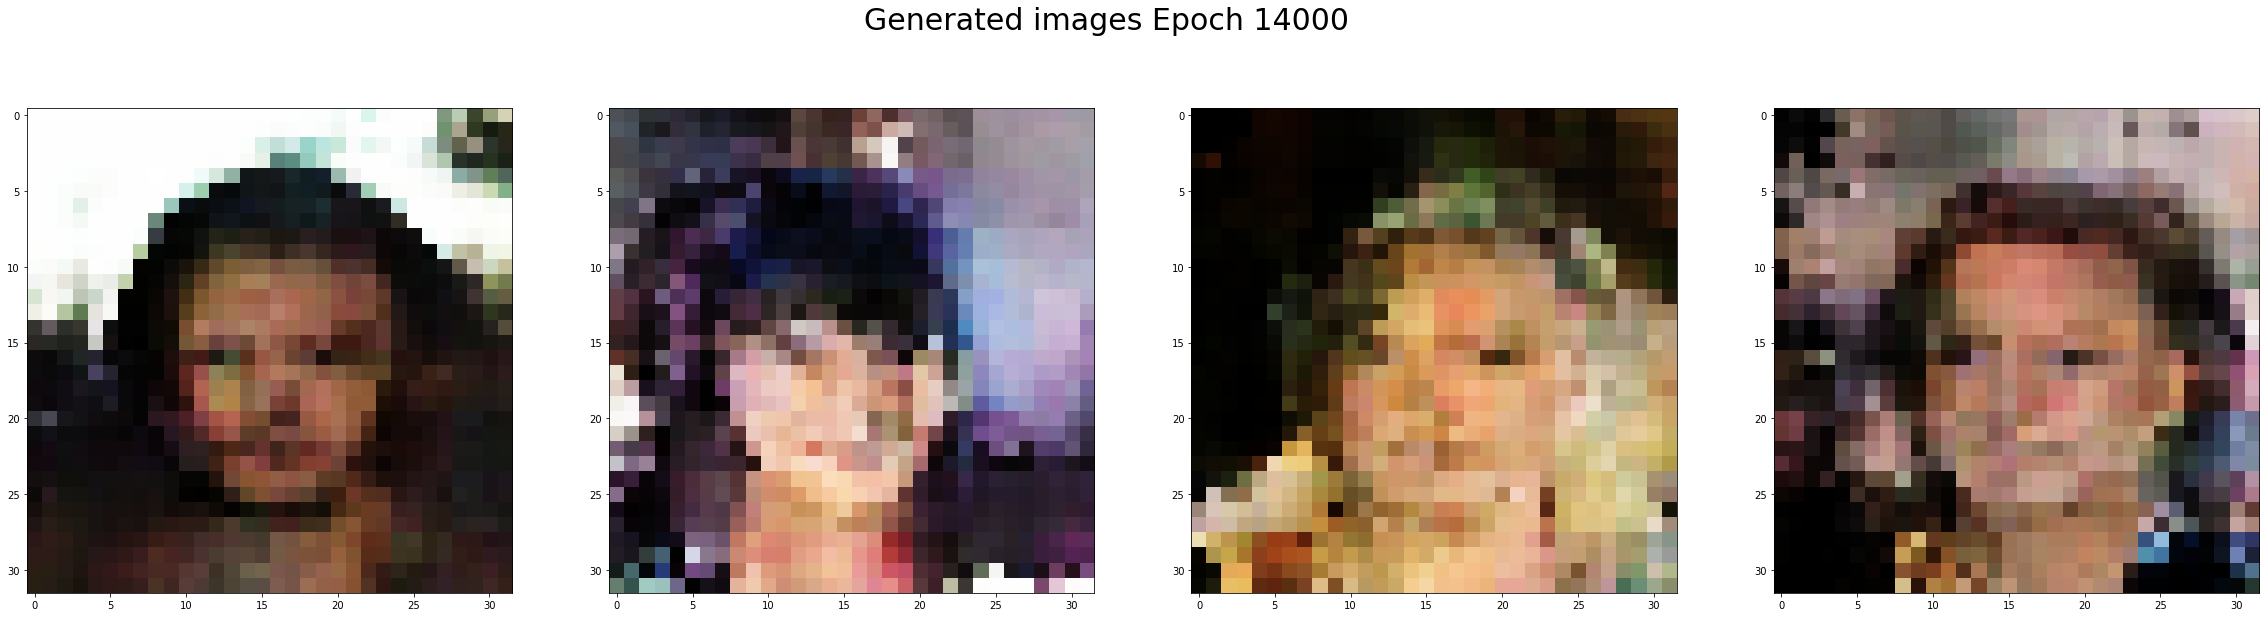

Epoch 14100 [D loss: 0.565, acc.: 069.2%] [G loss: 1.193]
Epoch 14200 [D loss: 0.536, acc.: 071.7%] [G loss: 1.234]
Epoch 14300 [D loss: 0.535, acc.: 073.0%] [G loss: 1.186]
Epoch 14400 [D loss: 0.536, acc.: 072.6%] [G loss: 1.229]
Epoch 14500 [D loss: 0.527, acc.: 073.0%] [G loss: 1.206]
Epoch 14600 [D loss: 0.523, acc.: 073.1%] [G loss: 1.220]
Epoch 14700 [D loss: 0.581, acc.: 068.2%] [G loss: 1.167]
Epoch 14800 [D loss: 0.536, acc.: 072.5%] [G loss: 1.176]
Epoch 14900 [D loss: 0.544, acc.: 071.8%] [G loss: 1.178]
Epoch 15000 [D loss: 0.543, acc.: 071.2%] [G loss: 1.196]


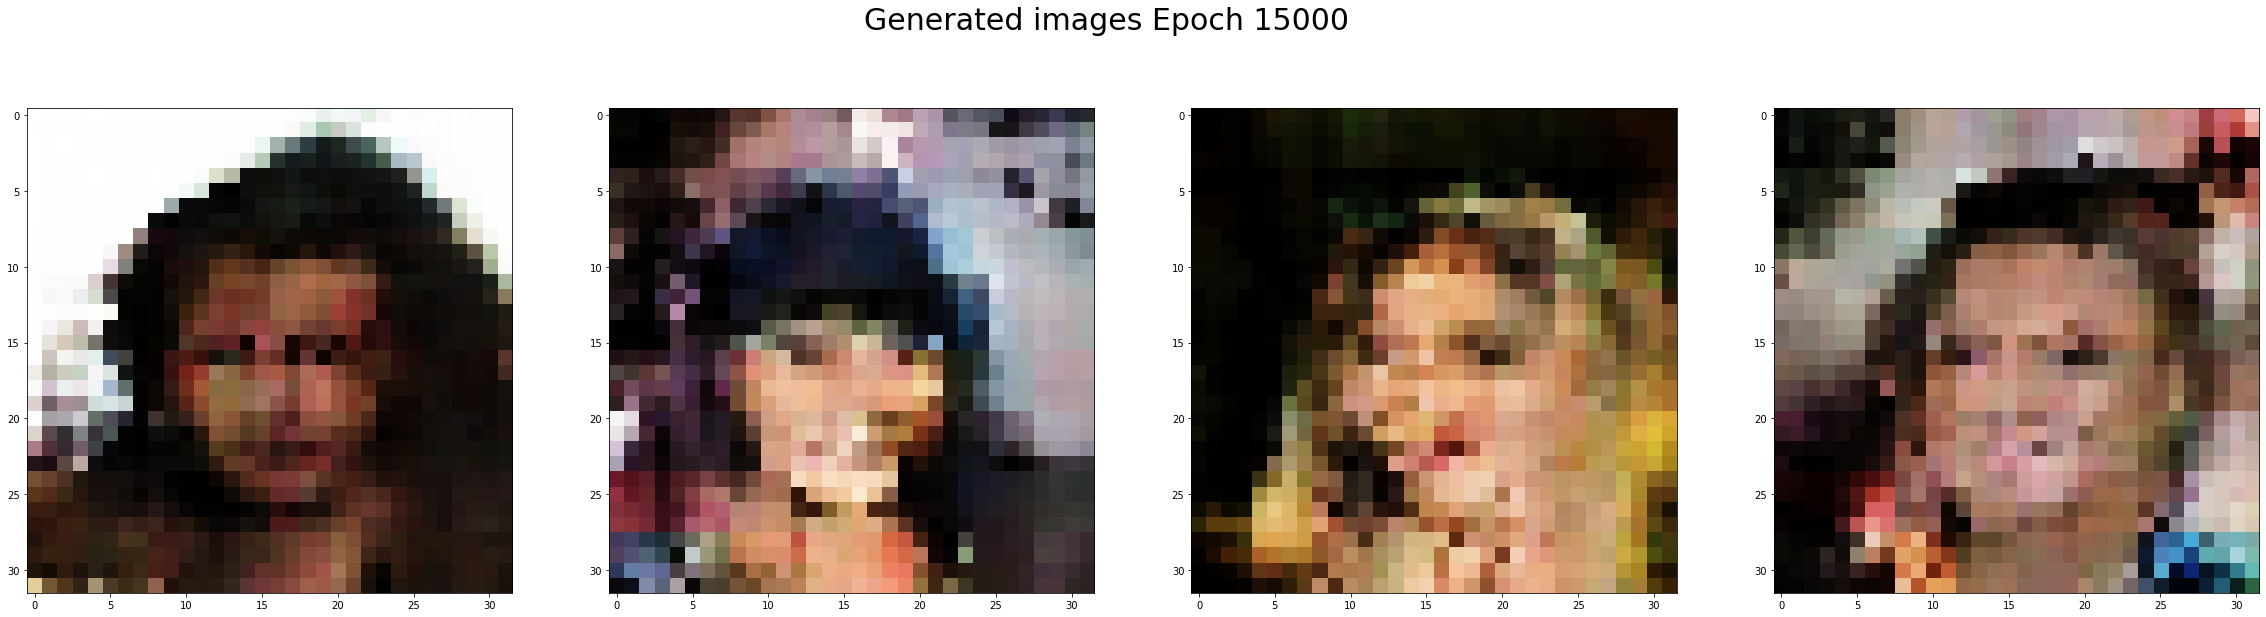

Epoch 15100 [D loss: 0.520, acc.: 073.9%] [G loss: 1.164]
Epoch 15200 [D loss: 0.551, acc.: 071.7%] [G loss: 1.242]
Epoch 15300 [D loss: 0.516, acc.: 073.7%] [G loss: 1.207]
Epoch 15400 [D loss: 0.517, acc.: 073.0%] [G loss: 1.192]
Epoch 15500 [D loss: 0.532, acc.: 072.4%] [G loss: 1.173]
Epoch 15600 [D loss: 0.533, acc.: 072.7%] [G loss: 1.162]
Epoch 15700 [D loss: 0.538, acc.: 071.5%] [G loss: 1.196]
Epoch 15800 [D loss: 0.544, acc.: 071.4%] [G loss: 1.187]
Epoch 15900 [D loss: 0.522, acc.: 071.9%] [G loss: 1.191]
Epoch 16000 [D loss: 0.508, acc.: 075.7%] [G loss: 1.186]


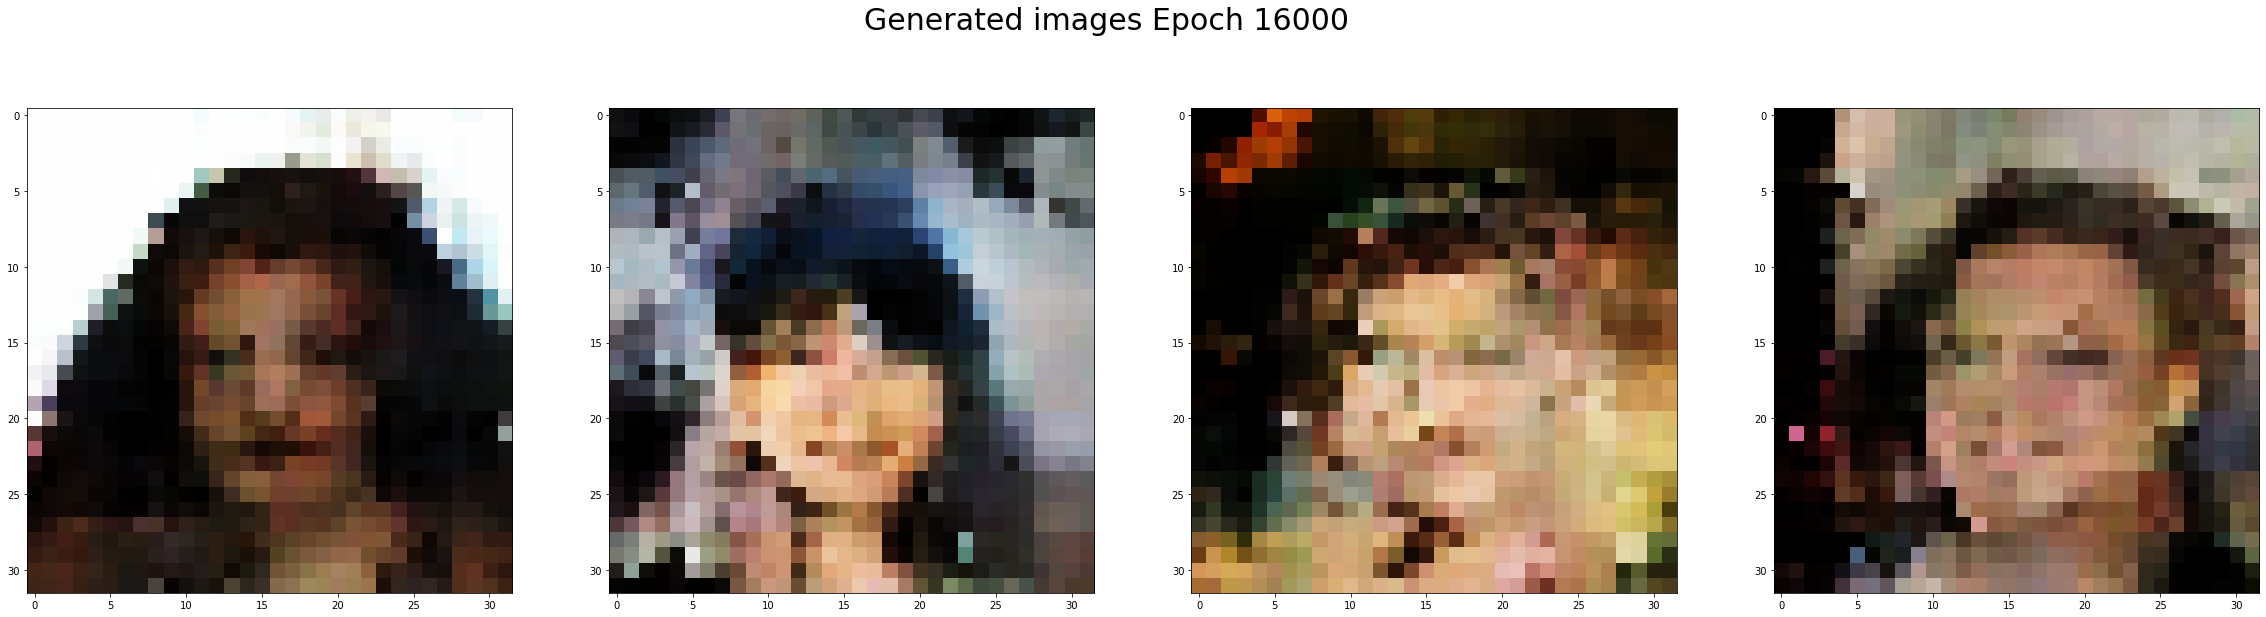

Epoch 16100 [D loss: 0.547, acc.: 070.4%] [G loss: 1.161]
Epoch 16200 [D loss: 0.528, acc.: 071.8%] [G loss: 1.185]
Epoch 16300 [D loss: 0.509, acc.: 074.4%] [G loss: 1.174]
Epoch 16400 [D loss: 0.547, acc.: 071.1%] [G loss: 1.221]
Epoch 16500 [D loss: 0.525, acc.: 074.2%] [G loss: 1.211]
Epoch 16600 [D loss: 0.530, acc.: 072.8%] [G loss: 1.173]
Epoch 16700 [D loss: 0.532, acc.: 072.9%] [G loss: 1.190]
Epoch 16800 [D loss: 0.496, acc.: 076.0%] [G loss: 1.202]
Epoch 16900 [D loss: 0.524, acc.: 074.8%] [G loss: 1.228]
Epoch 17000 [D loss: 0.519, acc.: 072.5%] [G loss: 1.225]


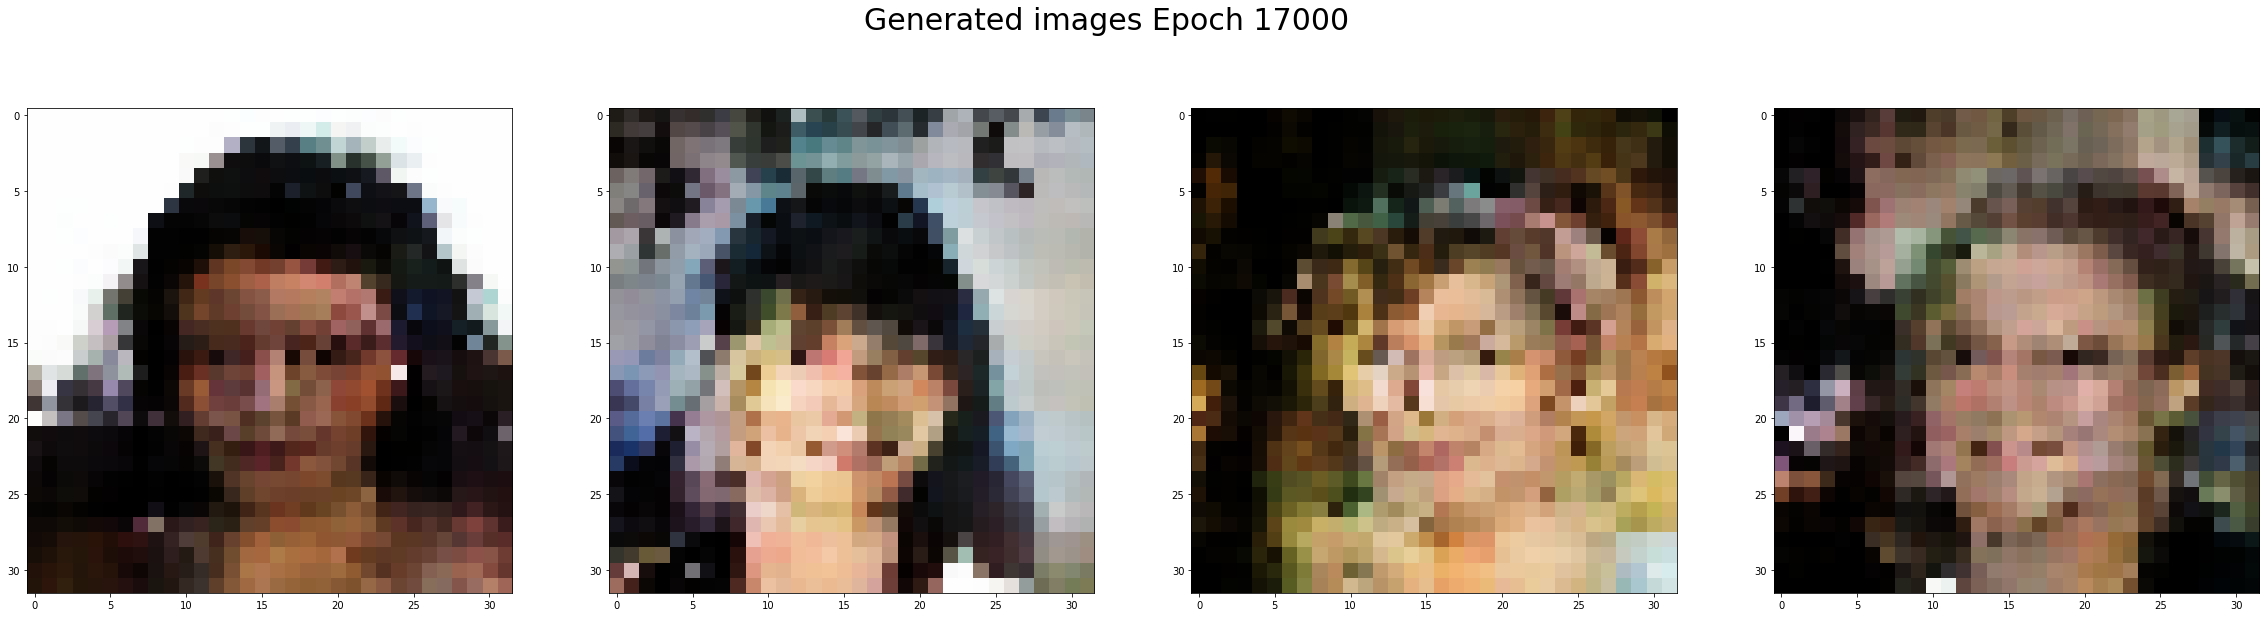

Epoch 17100 [D loss: 0.521, acc.: 073.2%] [G loss: 1.230]
Epoch 17200 [D loss: 0.539, acc.: 071.9%] [G loss: 1.232]
Epoch 17300 [D loss: 0.536, acc.: 072.4%] [G loss: 1.218]
Epoch 17400 [D loss: 0.506, acc.: 074.2%] [G loss: 1.250]
Epoch 17500 [D loss: 0.522, acc.: 075.0%] [G loss: 1.218]
Epoch 17600 [D loss: 0.518, acc.: 074.1%] [G loss: 1.232]
Epoch 17700 [D loss: 0.525, acc.: 073.0%] [G loss: 1.201]
Epoch 17800 [D loss: 0.510, acc.: 073.7%] [G loss: 1.228]
Epoch 17900 [D loss: 0.524, acc.: 072.5%] [G loss: 1.228]
Epoch 18000 [D loss: 0.527, acc.: 072.6%] [G loss: 1.216]


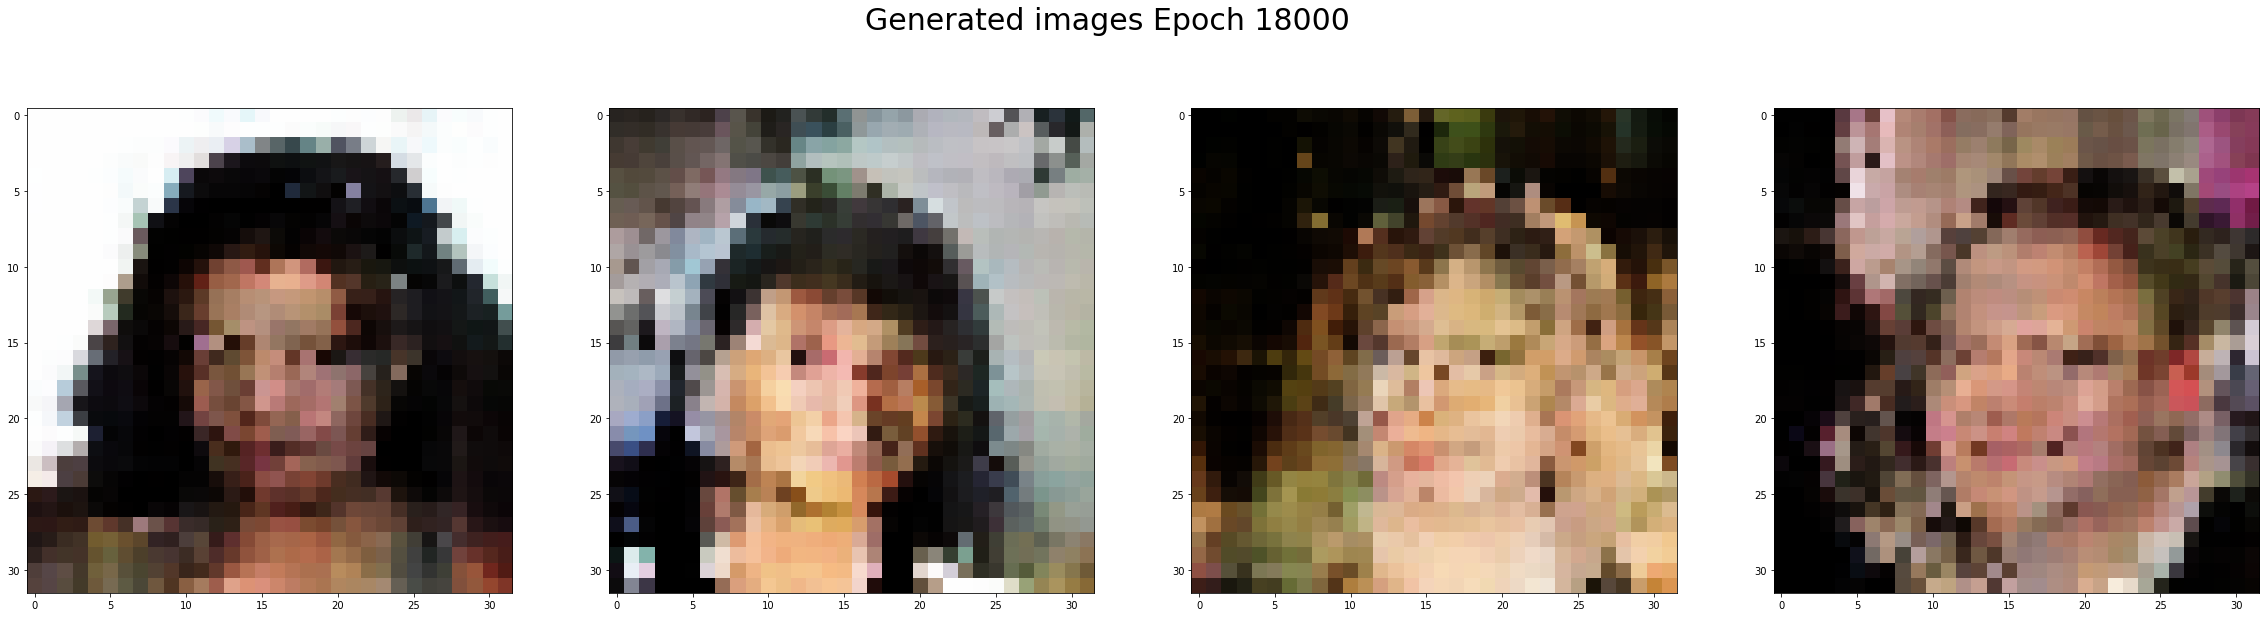

Epoch 18100 [D loss: 0.503, acc.: 075.1%] [G loss: 1.196]
Epoch 18200 [D loss: 0.521, acc.: 073.6%] [G loss: 1.213]
Epoch 18300 [D loss: 0.512, acc.: 073.1%] [G loss: 1.249]
Epoch 18400 [D loss: 0.506, acc.: 074.7%] [G loss: 1.269]
Epoch 18500 [D loss: 0.486, acc.: 075.5%] [G loss: 1.214]
Epoch 18600 [D loss: 0.538, acc.: 072.9%] [G loss: 1.234]
Epoch 18700 [D loss: 0.503, acc.: 074.3%] [G loss: 1.317]
Epoch 18800 [D loss: 0.519, acc.: 074.5%] [G loss: 1.254]
Epoch 18900 [D loss: 0.488, acc.: 074.7%] [G loss: 1.292]
Epoch 19000 [D loss: 0.503, acc.: 075.9%] [G loss: 1.293]


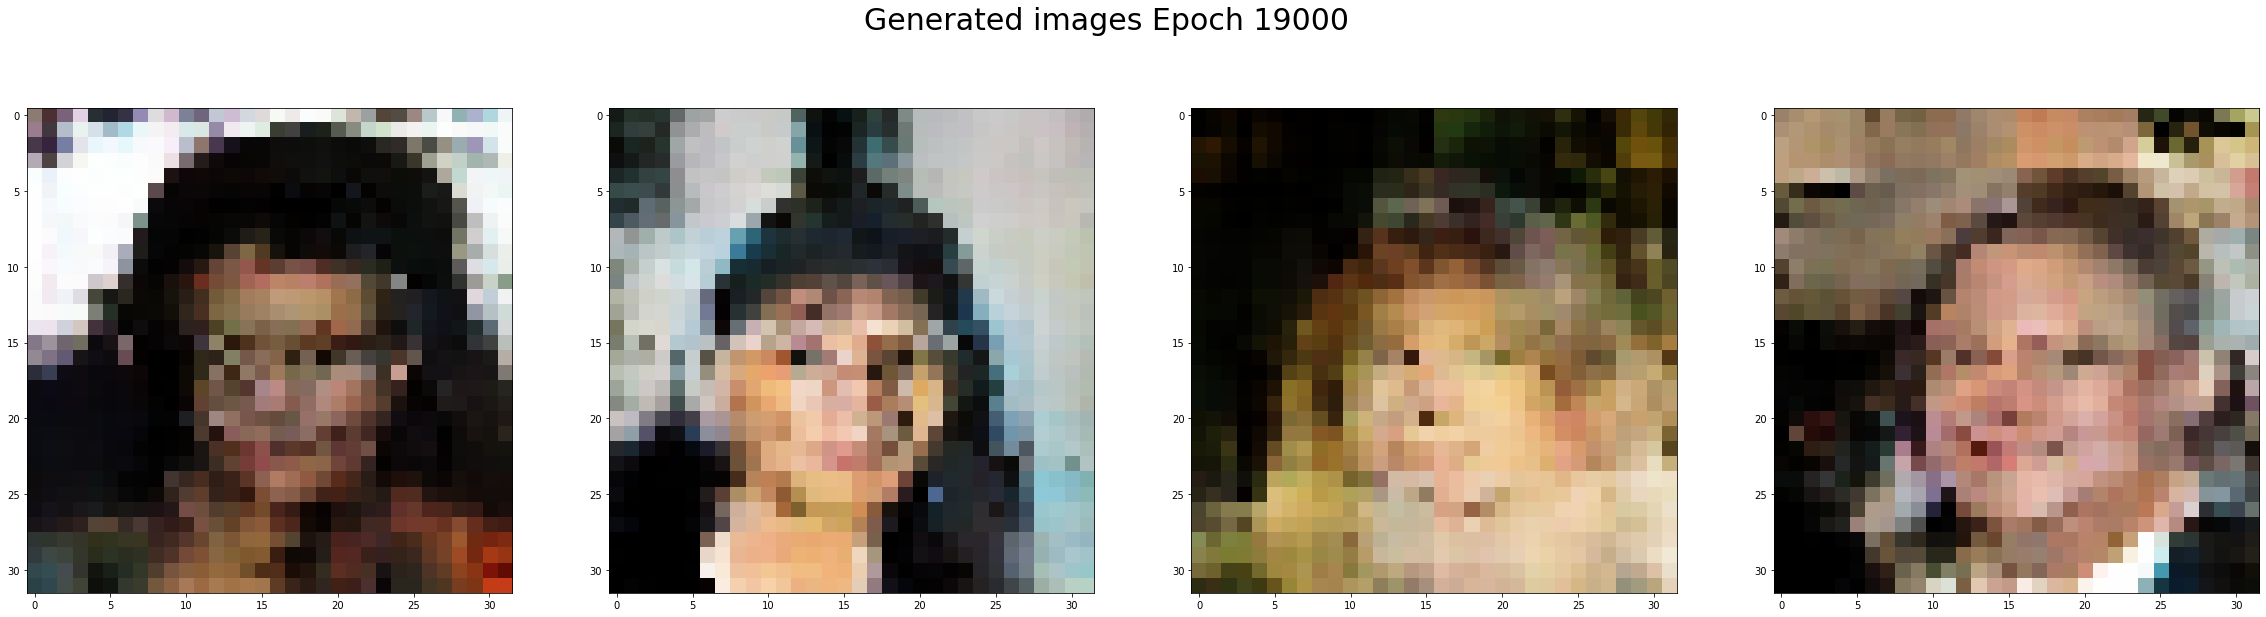

Epoch 19100 [D loss: 0.520, acc.: 072.9%] [G loss: 1.288]
Epoch 19200 [D loss: 0.531, acc.: 072.6%] [G loss: 1.286]
Epoch 19300 [D loss: 0.484, acc.: 076.3%] [G loss: 1.289]
Epoch 19400 [D loss: 0.491, acc.: 074.7%] [G loss: 1.283]
Epoch 19500 [D loss: 0.500, acc.: 074.2%] [G loss: 1.265]
Epoch 19600 [D loss: 0.507, acc.: 075.5%] [G loss: 1.308]
Epoch 19700 [D loss: 0.497, acc.: 074.2%] [G loss: 1.263]
Epoch 19800 [D loss: 0.498, acc.: 075.2%] [G loss: 1.356]
Epoch 19900 [D loss: 0.504, acc.: 074.4%] [G loss: 1.276]
----------
Time took: 83.25 min


In [26]:
def train(models, X_train, noise_plot, dir_result="/result/", epochs=10000, batch_size=128):
        '''
        models     : tuple containins three tensors, (combined, discriminator, generator)
        X_train    : np.array containing images (Nsample, height, width, Nchannels)
        noise_plot : np.array of size (Nrandom_sample_to_plot, hidden unit length)
        dir_result : the location where the generated plots for noise_plot are saved 
        
        '''
        combined, discriminator, generator = models
        nlatent_dim = noise_plot.shape[1]
        half_batch  = int(batch_size / 2)
        history = []
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]
            noise = get_noise(half_batch, nlatent_dim)

            # Generate a half batch of new images
            gen_imgs = generator.predict(noise)

            
            # Train the discriminator q: better to mix them together?
            d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = get_noise(batch_size, nlatent_dim)

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = (np.array([1] * batch_size)).reshape(batch_size,1)
            
            # Train the generator
            g_loss = combined.train_on_batch(noise, valid_y)

            history.append({"D":d_loss[0],"G":g_loss})
            
            if epoch % 100 == 0:
                # Plot the progress
                print ("Epoch {:05.0f} [D loss: {:4.3f}, acc.: {:05.1f}%] [G loss: {:4.3f}]".format(
                    epoch, d_loss[0], 100*d_loss[1], g_loss))
            if epoch % int(epochs/100) == 0:
                plot_generated_images(noise_plot,
                                      path_save=dir_result+"/image_{:05.0f}.png".format(epoch),
                                      titleadd="Epoch {}".format(epoch))
            if epoch % 1000 == 0:
                plot_generated_images(noise_plot,
                                      titleadd="Epoch {}".format(epoch))
                        
        return(history)

dir_result="./result_GAN/"

try:
    os.mkdir(dir_result)
except:
    pass
    
start_time = time.time()

_models = combined, discriminator, generator          

history = train(_models, X_train, noise, dir_result=dir_result,epochs=20000, batch_size=128*8)
end_time = time.time()
print("-"*10)
print("Time took: {:4.2f} min".format((end_time - start_time)/60))

## Loss over epochs

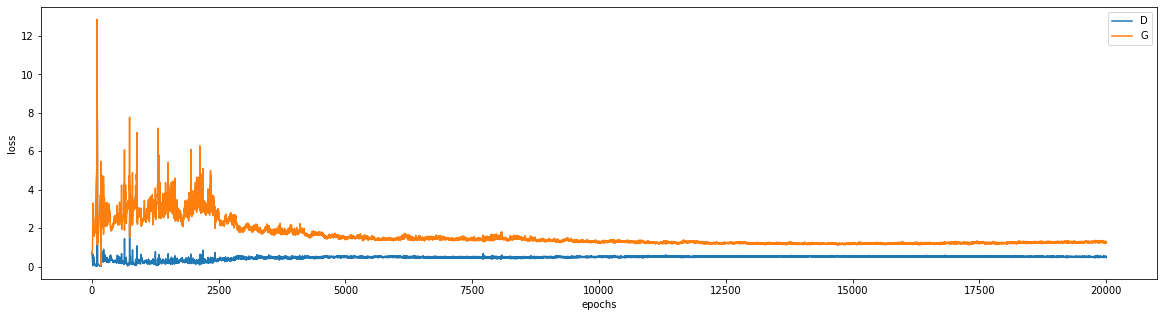

In [28]:
import pandas as pd 
hist = pd.DataFrame(history)
plt.figure(figsize=(20,5))
for colnm in hist.columns:
    plt.plot(hist[colnm],label=colnm)
plt.legend()
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

### gif of the generated images 

In [30]:
def makegif(dir_images):
    import imageio
    filenames = np.sort(os.listdir(dir_images))
    filenames = [ fnm for fnm in filenames if ".png" in fnm]

    with imageio.get_writer(dir_images + '/image.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(dir_images + filename)
            writer.append_data(image)
            os.remove(dir_images + filename)
            
makegif(dir_result)

In [31]:
img_in = layers.Input(shape=img_shape)

# discriminator with the final output layer = 100 network as encoder
discriminator_encoder = build_discriminator(img_shape,100)

# discriminator as encoder
encoder = discriminator_encoder(img_in)

# generator as decoder
generator.trainable = False
img_out = generator(encoder) 

encoder_decoder = models.Model(img_in,img_out)
encoder_decoder.compile(loss='mse', optimizer=optimizer)

encoder_decoder.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
functional_7 (Functional)    (None, 100)               6813060   
_________________________________________________________________
functional_1 (Functional)    (None, 32, 32, 3)         8584515   
Total params: 15,397,575
Trainable params: 6,813,060
Non-trainable params: 8,584,515
_________________________________________________________________


In [32]:
start_time = time.time()
history_ed = encoder_decoder.fit(X_train,X_train,
                                 validation_data=(X_test,X_test),
                                 epochs=10,verbose=2)
end_time = time.time()
print("-"*10)
print("Time took: {:4.2f} min".format((end_time - start_time)/60))

Train on 200000 samples, validate on 100 samples
Epoch 1/10
200000/200000 - 45s - loss: 0.0372 - val_loss: 0.0368
Epoch 2/10
200000/200000 - 45s - loss: 0.0347 - val_loss: 0.0359
Epoch 3/10
200000/200000 - 45s - loss: 0.0340 - val_loss: 0.0351
Epoch 4/10
200000/200000 - 45s - loss: 0.0335 - val_loss: 0.0349
Epoch 5/10
200000/200000 - 45s - loss: 0.0332 - val_loss: 0.0347
Epoch 6/10
200000/200000 - 45s - loss: 0.0330 - val_loss: 0.0344
Epoch 7/10
200000/200000 - 45s - loss: 0.0328 - val_loss: 0.0343
Epoch 8/10
200000/200000 - 45s - loss: 0.0326 - val_loss: 0.0341
Epoch 9/10
200000/200000 - 45s - loss: 0.0325 - val_loss: 0.0341
Epoch 10/10
200000/200000 - 45s - loss: 0.0324 - val_loss: 0.0340
----------
Time took: 7.47 min


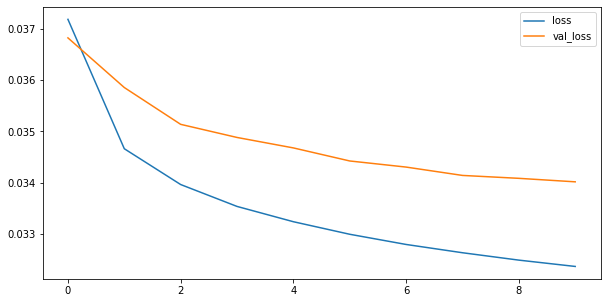

In [33]:
plt.figure(figsize=(10,5))
for colnm in history_ed.history.keys():
    plt.plot(history_ed.history[colnm],label=colnm)
plt.legend()
plt.show()

In [34]:
X_pred = encoder_decoder.predict(X_test)

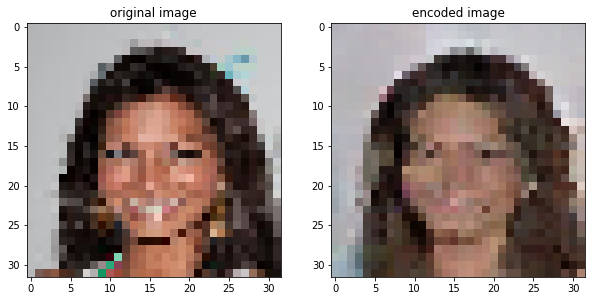

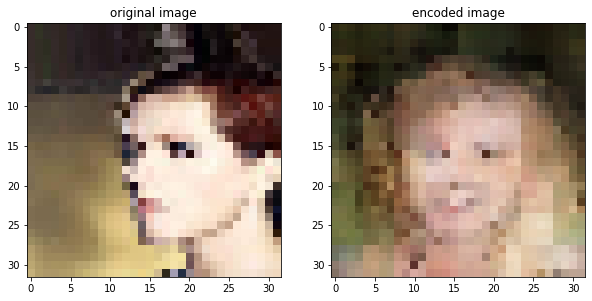

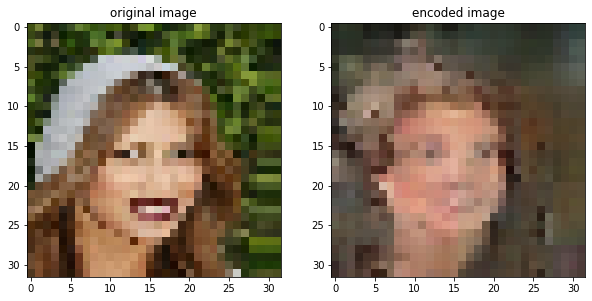

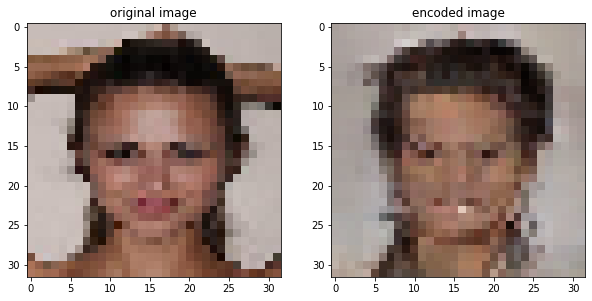

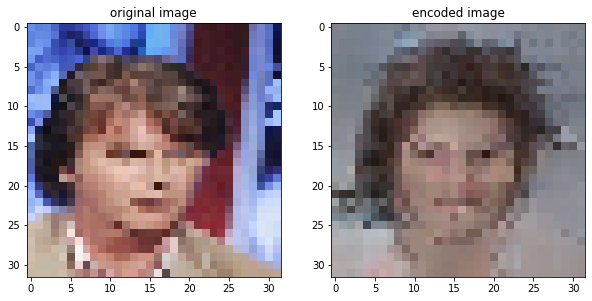

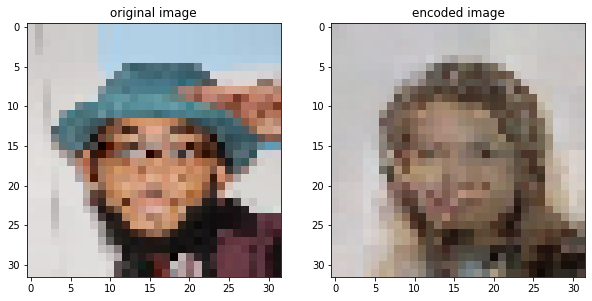

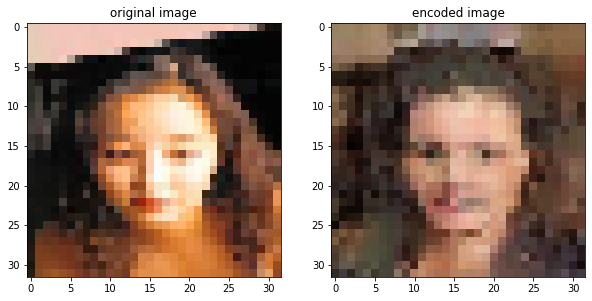

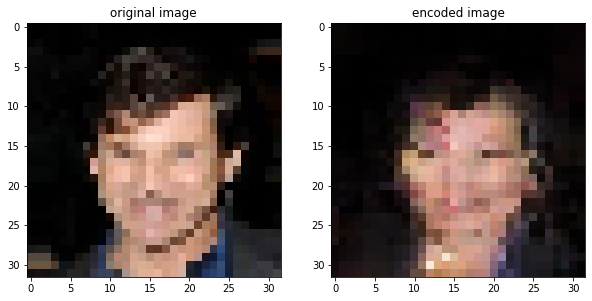

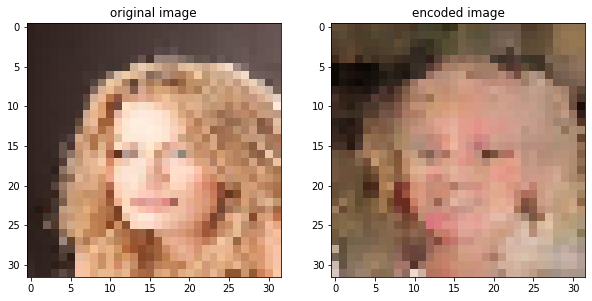

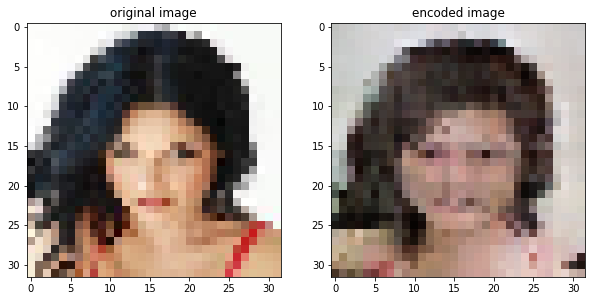

In [35]:
Ntest = 10

for irow in range(Ntest):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,2,1)
    ax.imshow(X_test[irow])
    ax.set_title("original image")
    
    ax = fig.add_subplot(1,2,2)
    ax.imshow(X_pred[irow])
    ax.set_title("encoded image")
    
    plt.show()